## PRAVEEN_SULONI_FINAL PROJECT

Name: Suloni Praveen
<br>
Github Username: sulonipr
<br>
USC ID: 6195368431
<br>
USC Email: sulonipr@usc.edu

### Imports


In [1]:
pip install opencv-python

In [2]:
pip install tensorflow

In [3]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten,  Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score,classification_report


### a) Reading through data files

In [4]:
from google.colab import drive
drive.mount('/content/drive')
DATASET_PATH = '/content/drive/MyDrive/data/RealWaste'
IMG_SIZE = (224, 224)

np.random.seed(42)

train_images = []
train_labels = []
test_images = []
test_labels = []

classes = os.listdir(DATASET_PATH)
classes = [c for c in classes if os.path.isdir(os.path.join(DATASET_PATH, c))]

def get_class_number(class_name):
    return int(class_name.split('-')[0])

classes.sort(key=get_class_number)
print(f"Found {len(classes)} classes (in order): {classes}")




Mounted at /content/drive
Found 9 classes (in order): ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']


### b) i) ii) Train-Test data split up and image Processing

In [5]:
total_train_files = 0
total_test_files = 0
processed_train_files = 0
processed_test_files = 0

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg'))]

    def get_image_number(filename):
        try:
            return int(filename.split('_')[-1].split('.')[0])
        except:
            return 0

    image_files.sort(key=get_image_number)

    # (80% for training and 20% for testing)
    split_idx = int(len(image_files) * 0.8)

    # Split into training and test sets
    train_files = image_files[:split_idx]
    test_files = image_files[split_idx:]

    total_train_files += len(train_files)
    total_test_files += len(test_files)

    class_train_processed = 0
    class_test_processed = 0

    # Process training images
    for img_file in train_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue

        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            train_images.append(img)
            train_labels.append(class_idx)
            class_train_processed += 1
            processed_train_files += 1

        except Exception as e:
            print(f"Error processing training image {img_path}: {e}")

    # Process test images
    for img_file in test_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue

        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            test_images.append(img)
            test_labels.append(class_idx)
            class_test_processed += 1
            processed_test_files += 1

        except Exception as e:
            print(f"Error processing test image {img_path}: {e}")

    print(f"Class {class_idx}: {class_name}: {len(train_files)} total train, {class_train_processed} processed")
    print(f"Class {class_idx}: {class_name}: {len(test_files)} total test, {class_test_processed} processed")

train_images = np.array(train_images, dtype=np.float32)
test_images = np.array(test_images, dtype=np.float32)

# Normalize pixel values to [0, 1]
# train_images = train_images / 255.0
# test_images = test_images / 255.0

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Converting to one-hot encoding
lb = LabelBinarizer()
train_labels_one_hot = lb.fit_transform(train_labels)
test_labels_one_hot = lb.transform(test_labels)

print(f"\nTotal images in training set (before processing): {total_train_files}")
print(f"Total images in test set (before processing): {total_test_files}")
print(f"Total images processed for training: {processed_train_files}")
print(f"Total images processed for testing: {processed_test_files}")
print(f"Final training set shape: {train_images.shape}")
print(f"Final test set shape: {test_images.shape}")
print(f"One-hot encoded train labels shape: {train_labels_one_hot.shape}")
print(f"One-hot encoded test labels shape: {test_labels_one_hot.shape}")


Class 0: 1-Cardboard: 368 total train, 368 processed
Class 0: 1-Cardboard: 93 total test, 93 processed
Class 1: 2-Food Organics: 328 total train, 328 processed
Class 1: 2-Food Organics: 83 total test, 83 processed
Class 2: 3-Glass: 336 total train, 336 processed
Class 2: 3-Glass: 84 total test, 84 processed
Class 3: 4-Metal: 632 total train, 632 processed
Class 3: 4-Metal: 158 total test, 158 processed
Class 4: 5-Miscellaneous Trash: 396 total train, 396 processed
Class 4: 5-Miscellaneous Trash: 99 total test, 99 processed
Class 5: 6-Paper: 400 total train, 400 processed
Class 5: 6-Paper: 100 total test, 100 processed
Class 6: 7-Plastic: 736 total train, 736 processed
Class 6: 7-Plastic: 185 total test, 185 processed
Class 7: 8-Textile Trash: 254 total train, 254 processed
Class 7: 8-Textile Trash: 64 total test, 64 processed
Class 8: 9-Vegetation: 348 total train, 348 processed
Class 8: 9-Vegetation: 88 total test, 88 processed

Total images in training set (before processing): 3798
T

### Validation data

In [6]:
train_images_final, val_images, train_labels_final, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=42
)

train_labels_one_hot_final = lb.transform(train_labels_final)
val_labels_one_hot = lb.transform(val_labels)

print(f"Final training set: {train_images_final.shape[0]} images")
print(f"Validation set: {val_images.shape[0]} images")
print(f"Test set: {test_images.shape[0]} images")
print(f"Final training labels shape: {train_labels_one_hot_final.shape}")
print(f"Validation labels shape: {val_labels_one_hot.shape}")

Final training set: 3038 images
Validation set: 760 images
Test set: 954 images
Final training labels shape: (3038, 9)
Validation labels shape: (760, 9)


In [7]:
print("\n--- One-Hot Encoding ---")
for i in range(min(9, len(classes))):
    indices = np.where(train_labels_final == i)[0]
    if len(indices) > 0:
        class_index = indices[0]
        one_hot_label = train_labels_one_hot_final[class_index]
        class_name = classes[i]
        print(f"Class {i}: {class_name}")
        print(f"One-hot encoded: {one_hot_label}")
        print()


--- One-Hot Encoding ---
Class 0: 1-Cardboard
One-hot encoded: [1 0 0 0 0 0 0 0 0]

Class 1: 2-Food Organics
One-hot encoded: [0 1 0 0 0 0 0 0 0]

Class 2: 3-Glass
One-hot encoded: [0 0 1 0 0 0 0 0 0]

Class 3: 4-Metal
One-hot encoded: [0 0 0 1 0 0 0 0 0]

Class 4: 5-Miscellaneous Trash
One-hot encoded: [0 0 0 0 1 0 0 0 0]

Class 5: 6-Paper
One-hot encoded: [0 0 0 0 0 1 0 0 0]

Class 6: 7-Plastic
One-hot encoded: [0 0 0 0 0 0 1 0 0]

Class 7: 8-Textile Trash
One-hot encoded: [0 0 0 0 0 0 0 1 0]

Class 8: 9-Vegetation
One-hot encoded: [0 0 0 0 0 0 0 0 1]



## c) Transfer Learning

### i) ii) iii) iv) Pre Trained models

In [8]:

def create_and_train_model(base_model_name, train_data, val_data, test_data=None, input_shape=(224, 224, 3), num_classes=9, epochs=100):

    train_images, train_labels = train_data
    val_images, val_labels = val_data
    train_size = train_images.shape[0]
    batch_size = 5
    steps_per_epoch = math.ceil(train_size / batch_size)

    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
        RandomContrast(0.1)
    ])

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.shuffle(train_size * 10)
    train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    train_dataset = train_dataset.map(
        lambda x, y: (data_augmentation(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
    elif base_model_name == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
    else:
        raise ValueError(f"Unsupported model: {base_model_name}")

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.02))
    ])

    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]

    try:
        metrics.append(tf.keras.metrics.F1Score(name='f1_score'))
    except:
        print("F1Score metric not available")

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metrics
    )

    model.summary()

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            restore_best_weights=True,
            min_delta=0.001
        ),
        ModelCheckpoint(
            f"{base_model_name}_best_model.h5",
            monitor='val_loss',
            save_best_only=True,
            verbose=1,
            mode='min'
        )
    ]

    print(f"Training with {steps_per_epoch} steps per epoch")

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=1
    )

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{base_model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{base_model_name}_loss.png")
    plt.show()

    # Load the best model
    best_model = tf.keras.models.load_model(f"{base_model_name}_best_model.h5")


    results = None
    if test_data is not None:
        test_images, test_labels = test_data
        test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
        test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

        tf_results = best_model.evaluate(test_dataset, verbose=0)
        metrics_names = ['loss'] + [m.name if hasattr(m, 'name') else m for m in metrics]
        results_dict = dict(zip(metrics_names, tf_results))

        results = results_dict

    return best_model, history, results

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ResNet50

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,643,465 (94.01 MB)

 Trainable params: 1,054,729 (4.02 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

Training with 760 steps per epoch
Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3850 - auc: 0.7703 - f1_score: 0.3717 - loss: 17.2179 - precision: 0.4883 - recall: 0.2821
Epoch 1: val_loss improved from inf to 13.11271, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.3852 - auc: 0.7704 - f1_score: 0.3718 - loss: 17.2160 - precision: 0.4885 - recall: 0.2823 - val_accuracy: 0.7474 - val_auc: 0.9568 - val_f1_score: 0.7464 - val_loss: 13.1127 - val_precision: 0.7979 - val_recall: 0.7066
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6464 - auc: 0.9303 - f1_score: 0.6419 - loss: 12.5524 - precision: 0.7300 - recall: 0.5630
Epoch 2: val_loss improved from 13.11271 to 9.98992, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6464 - auc: 0.9303 - f1_score: 0.6419 - loss: 12.5514 - precision: 0.7300 - recall: 0.5630 - val_accuracy: 0.7855 - val_auc: 0.9692 - val_f1_score: 0.7810 - val_loss: 9.9899 - val_precision: 0.8324 - val_recall: 0.7579
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7177 - auc: 0.9529 - f1_score: 0.7099 - loss: 9.5617 - precision: 0.7881 - recall: 0.6408
Epoch 3: val_loss improved from 9.98992 to 7.56564, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7177 - auc: 0.9529 - f1_score: 0.7099 - loss: 9.5610 - precision: 0.7881 - recall: 0.6408 - val_accuracy: 0.8316 - val_auc: 0.9818 - val_f1_score: 0.8327 - val_loss: 7.5656 - val_precision: 0.8636 - val_recall: 0.8000
Epoch 4/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7272 - auc: 0.9556 - f1_score: 0.7307 - loss: 7.4083 - precision: 0.7891 - recall: 0.6593
Epoch 4: val_loss improved from 7.56564 to 5.84674, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7272 - auc: 0.9556 - f1_score: 0.7307 - loss: 7.4071 - precision: 0.7891 - recall: 0.6593 - val_accuracy: 0.8447 - val_auc: 0.9830 - val_f1_score: 0.8399 - val_loss: 5.8467 - val_precision: 0.8745 - val_recall: 0.8250
Epoch 5/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7473 - auc: 0.9622 - f1_score: 0.7446 - loss: 5.7783 - precision: 0.8133 - recall: 0.6897
Epoch 5: val_loss improved from 5.84674 to 4.61626, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7474 - auc: 0.9622 - f1_score: 0.7446 - loss: 5.7771 - precision: 0.8133 - recall: 0.6897 - val_accuracy: 0.8408 - val_auc: 0.9821 - val_f1_score: 0.8449 - val_loss: 4.6163 - val_precision: 0.8690 - val_recall: 0.8118
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7577 - auc: 0.9643 - f1_score: 0.7581 - loss: 4.5948 - precision: 0.8288 - recall: 0.6955
Epoch 6: val_loss improved from 4.61626 to 3.73842, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7577 - auc: 0.9643 - f1_score: 0.7581 - loss: 4.5945 - precision: 0.8288 - recall: 0.6955 - val_accuracy: 0.8395 - val_auc: 0.9794 - val_f1_score: 0.8386 - val_loss: 3.7384 - val_precision: 0.8682 - val_recall: 0.8237
Epoch 7/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7716 - auc: 0.9705 - f1_score: 0.7708 - loss: 3.7069 - precision: 0.8472 - recall: 0.7066
Epoch 7: val_loss improved from 3.73842 to 3.01990, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7716 - auc: 0.9705 - f1_score: 0.7708 - loss: 3.7065 - precision: 0.8472 - recall: 0.7066 - val_accuracy: 0.8421 - val_auc: 0.9836 - val_f1_score: 0.8358 - val_loss: 3.0199 - val_precision: 0.8666 - val_recall: 0.8118
Epoch 8/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7694 - auc: 0.9713 - f1_score: 0.7724 - loss: 3.0826 - precision: 0.8378 - recall: 0.7035
Epoch 8: val_loss improved from 3.01990 to 2.52484, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7694 - auc: 0.9713 - f1_score: 0.7724 - loss: 3.0824 - precision: 0.8378 - recall: 0.7035 - val_accuracy: 0.8461 - val_auc: 0.9829 - val_f1_score: 0.8485 - val_loss: 2.5248 - val_precision: 0.8743 - val_recall: 0.8145
Epoch 9/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7917 - auc: 0.9759 - f1_score: 0.7909 - loss: 2.5624 - precision: 0.8598 - recall: 0.7258
Epoch 9: val_loss improved from 2.52484 to 2.19667, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7917 - auc: 0.9759 - f1_score: 0.7909 - loss: 2.5623 - precision: 0.8598 - recall: 0.7258 - val_accuracy: 0.8329 - val_auc: 0.9795 - val_f1_score: 0.8329 - val_loss: 2.1967 - val_precision: 0.8698 - val_recall: 0.8000
Epoch 10/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8090 - auc: 0.9765 - f1_score: 0.8130 - loss: 2.1899 - precision: 0.8679 - recall: 0.7413
Epoch 10: val_loss improved from 2.19667 to 1.94599, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8090 - auc: 0.9765 - f1_score: 0.8130 - loss: 2.1899 - precision: 0.8678 - recall: 0.7413 - val_accuracy: 0.8263 - val_auc: 0.9777 - val_f1_score: 0.8265 - val_loss: 1.9460 - val_precision: 0.8571 - val_recall: 0.7974
Epoch 11/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7943 - auc: 0.9749 - f1_score: 0.7962 - loss: 1.9531 - precision: 0.8582 - recall: 0.7296
Epoch 11: val_loss improved from 1.94599 to 1.61243, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7943 - auc: 0.9749 - f1_score: 0.7962 - loss: 1.9530 - precision: 0.8582 - recall: 0.7296 - val_accuracy: 0.8566 - val_auc: 0.9869 - val_f1_score: 0.8529 - val_loss: 1.6124 - val_precision: 0.8920 - val_recall: 0.8368
Epoch 12/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8027 - auc: 0.9800 - f1_score: 0.7991 - loss: 1.7036 - precision: 0.8711 - recall: 0.7388
Epoch 12: val_loss improved from 1.61243 to 1.39945, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8027 - auc: 0.9800 - f1_score: 0.7991 - loss: 1.7035 - precision: 0.8711 - recall: 0.7388 - val_accuracy: 0.8711 - val_auc: 0.9895 - val_f1_score: 0.8675 - val_loss: 1.3994 - val_precision: 0.9079 - val_recall: 0.8434
Epoch 13/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8226 - auc: 0.9808 - f1_score: 0.8216 - loss: 1.5309 - precision: 0.8826 - recall: 0.7612
Epoch 13: val_loss improved from 1.39945 to 1.33726, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8225 - auc: 0.9808 - f1_score: 0.8216 - loss: 1.5309 - precision: 0.8826 - recall: 0.7611 - val_accuracy: 0.8592 - val_auc: 0.9854 - val_f1_score: 0.8557 - val_loss: 1.3373 - val_precision: 0.8898 - val_recall: 0.8289
Epoch 14/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8066 - auc: 0.9784 - f1_score: 0.8082 - loss: 1.4449 - precision: 0.8751 - recall: 0.7426
Epoch 14: val_loss improved from 1.33726 to 1.27975, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8066 - auc: 0.9784 - f1_score: 0.8082 - loss: 1.4449 - precision: 0.8751 - recall: 0.7426 - val_accuracy: 0.8382 - val_auc: 0.9825 - val_f1_score: 0.8352 - val_loss: 1.2797 - val_precision: 0.8690 - val_recall: 0.8118
Epoch 15/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8126 - auc: 0.9791 - f1_score: 0.8119 - loss: 1.3399 - precision: 0.8705 - recall: 0.7442
Epoch 15: val_loss improved from 1.27975 to 1.14483, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8126 - auc: 0.9791 - f1_score: 0.8119 - loss: 1.3400 - precision: 0.8705 - recall: 0.7442 - val_accuracy: 0.8658 - val_auc: 0.9879 - val_f1_score: 0.8653 - val_loss: 1.1448 - val_precision: 0.8864 - val_recall: 0.8316
Epoch 16/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8101 - auc: 0.9805 - f1_score: 0.8142 - loss: 1.2615 - precision: 0.8636 - recall: 0.7427
Epoch 16: val_loss improved from 1.14483 to 1.00499, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8101 - auc: 0.9805 - f1_score: 0.8142 - loss: 1.2615 - precision: 0.8636 - recall: 0.7427 - val_accuracy: 0.8829 - val_auc: 0.9920 - val_f1_score: 0.8844 - val_loss: 1.0050 - val_precision: 0.9103 - val_recall: 0.8684
Epoch 17/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8113 - auc: 0.9798 - f1_score: 0.8128 - loss: 1.2211 - precision: 0.8802 - recall: 0.7403
Epoch 17: val_loss did not improve from 1.00499
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8113 - auc: 0.9798 - f1_score: 0.8128 - loss: 1.2211 - precision: 0.8802 - recall: 0.7403 - val_accuracy: 0.8711 - val_auc: 0.9858 - val_f1_score: 0.8671 - val_loss: 1.0441 - val_precision: 0.8974 - val_recall: 0.8289
Epoch 18/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8013 - auc: 0.9801 - f1_score: 0.8063 - loss: 1.1699 - precision: 0.8724 - recall: 0.7393
Epoch 18: val_loss did not improve from 1.00499
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24m

760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8057 - auc: 0.9785 - f1_score: 0.8027 - loss: 1.1512 - precision: 0.8668 - recall: 0.7314 - val_accuracy: 0.8553 - val_auc: 0.9850 - val_f1_score: 0.8480 - val_loss: 0.9936 - val_precision: 0.8815 - val_recall: 0.8224
Epoch 20/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8267 - auc: 0.9800 - f1_score: 0.8297 - loss: 1.0952 - precision: 0.8855 - recall: 0.7495
Epoch 20: val_loss did not improve from 0.99363
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8267 - auc: 0.9800 - f1_score: 0.8297 - loss: 1.0952 - precision: 0.8855 - recall: 0.7495 - val_accuracy: 0.8434 - val_auc: 0.9806 - val_f1_score: 0.8320 - val_loss: 1.0006 - val_precision: 0.8773 - val_recall: 0.8184
Epoch 21/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8217 - auc: 0.9799 - f1_score: 0.8263 - loss: 1.0576 - precision: 0.8911 - recall: 0.7459
Epoch 21: val_loss improved from 0.99363 to 0.92532, saving model to ResNet50_best_m

760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8216 - auc: 0.9799 - f1_score: 0.8263 - loss: 1.0576 - precision: 0.8911 - recall: 0.7458 - val_accuracy: 0.8447 - val_auc: 0.9857 - val_f1_score: 0.8457 - val_loss: 0.9253 - val_precision: 0.8769 - val_recall: 0.8158
Epoch 22/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8103 - auc: 0.9789 - f1_score: 0.8117 - loss: 1.0576 - precision: 0.8833 - recall: 0.7322
Epoch 22: val_loss improved from 0.92532 to 0.88521, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8103 - auc: 0.9789 - f1_score: 0.8117 - loss: 1.0576 - precision: 0.8832 - recall: 0.7322 - val_accuracy: 0.8447 - val_auc: 0.9883 - val_f1_score: 0.8444 - val_loss: 0.8852 - val_precision: 0.8653 - val_recall: 0.8197
Epoch 23/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8127 - auc: 0.9800 - f1_score: 0.8161 - loss: 1.0233 - precision: 0.8846 - recall: 0.7467
Epoch 23: val_loss did not improve from 0.88521
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8127 - auc: 0.9800 - f1_score: 0.8161 - loss: 1.0233 - precision: 0.8845 - recall: 0.7466 - val_accuracy: 0.8474 - val_auc: 0.9848 - val_f1_score: 0.8372 - val_loss: 0.8909 - val_precision: 0.8784 - val_recall: 0.8171
Epoch 24/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8098 - auc: 0.9800 - f1_score: 0.8160 - loss: 1.0043 - precision: 0.8806 - recall: 0.7397
Epoch 24: val_loss improved from 0.88521 to 0.87505, saving model to ResNet50_best_m

760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8098 - auc: 0.9800 - f1_score: 0.8160 - loss: 1.0043 - precision: 0.8806 - recall: 0.7397 - val_accuracy: 0.8513 - val_auc: 0.9864 - val_f1_score: 0.8494 - val_loss: 0.8751 - val_precision: 0.8898 - val_recall: 0.8184
Epoch 25/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8203 - auc: 0.9817 - f1_score: 0.8277 - loss: 0.9683 - precision: 0.8823 - recall: 0.7444
Epoch 25: val_loss improved from 0.87505 to 0.86943, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8203 - auc: 0.9817 - f1_score: 0.8276 - loss: 0.9684 - precision: 0.8823 - recall: 0.7444 - val_accuracy: 0.8566 - val_auc: 0.9847 - val_f1_score: 0.8596 - val_loss: 0.8694 - val_precision: 0.8782 - val_recall: 0.8250
Epoch 26/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8117 - auc: 0.9804 - f1_score: 0.8141 - loss: 0.9678 - precision: 0.8748 - recall: 0.7437
Epoch 26: val_loss improved from 0.86943 to 0.78882, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8117 - auc: 0.9804 - f1_score: 0.8141 - loss: 0.9678 - precision: 0.8748 - recall: 0.7437 - val_accuracy: 0.8697 - val_auc: 0.9900 - val_f1_score: 0.8711 - val_loss: 0.7888 - val_precision: 0.9013 - val_recall: 0.8408
Epoch 27/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8159 - auc: 0.9800 - f1_score: 0.8184 - loss: 0.9597 - precision: 0.8736 - recall: 0.7491
Epoch 27: val_loss improved from 0.78882 to 0.78480, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8159 - auc: 0.9800 - f1_score: 0.8184 - loss: 0.9598 - precision: 0.8735 - recall: 0.7490 - val_accuracy: 0.8553 - val_auc: 0.9902 - val_f1_score: 0.8535 - val_loss: 0.7848 - val_precision: 0.8916 - val_recall: 0.8224
Epoch 28/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8234 - auc: 0.9817 - f1_score: 0.8245 - loss: 0.9462 - precision: 0.8793 - recall: 0.7502
Epoch 28: val_loss did not improve from 0.78480
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8233 - auc: 0.9817 - f1_score: 0.8245 - loss: 0.9462 - precision: 0.8793 - recall: 0.7502 - val_accuracy: 0.8724 - val_auc: 0.9883 - val_f1_score: 0.8712 - val_loss: 0.7881 - val_precision: 0.8942 - val_recall: 0.8342
Epoch 29/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8168 - auc: 0.9792 - f1_score: 0.8219 - loss: 0.9521 - precision: 0.8779 - recall: 0.7399
Epoch 29: val_loss improved from 0.78480 to 0.77859, saving model to ResNet50_best_m

760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8168 - auc: 0.9792 - f1_score: 0.8219 - loss: 0.9521 - precision: 0.8779 - recall: 0.7399 - val_accuracy: 0.8724 - val_auc: 0.9861 - val_f1_score: 0.8677 - val_loss: 0.7786 - val_precision: 0.9042 - val_recall: 0.8447
Epoch 30/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8328 - auc: 0.9830 - f1_score: 0.8352 - loss: 0.8958 - precision: 0.9041 - recall: 0.7662
Epoch 30: val_loss improved from 0.77859 to 0.71044, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8328 - auc: 0.9830 - f1_score: 0.8351 - loss: 0.8958 - precision: 0.9041 - recall: 0.7662 - val_accuracy: 0.8947 - val_auc: 0.9915 - val_f1_score: 0.8984 - val_loss: 0.7104 - val_precision: 0.9191 - val_recall: 0.8526
Epoch 31/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8099 - auc: 0.9805 - f1_score: 0.8148 - loss: 0.9302 - precision: 0.8690 - recall: 0.7332
Epoch 31: val_loss did not improve from 0.71044
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8099 - auc: 0.9805 - f1_score: 0.8148 - loss: 0.9302 - precision: 0.8691 - recall: 0.7333 - val_accuracy: 0.8474 - val_auc: 0.9885 - val_f1_score: 0.8432 - val_loss: 0.7730 - val_precision: 0.8889 - val_recall: 0.8211
Epoch 32/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8230 - auc: 0.9815 - f1_score: 0.8289 - loss: 0.9038 - precision: 0.8894 - recall: 0.7587
Epoch 32: val_loss did not improve from 0.71044
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24m

760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8348 - auc: 0.9826 - f1_score: 0.8361 - loss: 0.8582 - precision: 0.8961 - recall: 0.7785 - val_accuracy: 0.8816 - val_auc: 0.9892 - val_f1_score: 0.8825 - val_loss: 0.7044 - val_precision: 0.8990 - val_recall: 0.8553
Epoch 39/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8197 - auc: 0.9830 - f1_score: 0.8244 - loss: 0.8629 - precision: 0.8903 - recall: 0.7442
Epoch 39: val_loss did not improve from 0.70444
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8197 - auc: 0.9830 - f1_score: 0.8244 - loss: 0.8629 - precision: 0.8903 - recall: 0.7442 - val_accuracy: 0.8803 - val_auc: 0.9892 - val_f1_score: 0.8758 - val_loss: 0.7200 - val_precision: 0.8986 - val_recall: 0.8513
Epoch 40/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8193 - auc: 0.9803 - f1_score: 0.8239 - loss: 0.8900 - precision: 0.8857 - recall: 0.7411
Epoch 40: val_loss did not improve from 0.70444
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24m

760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8320 - auc: 0.9818 - f1_score: 0.8328 - loss: 0.8648 - precision: 0.8928 - recall: 0.7637 - val_accuracy: 0.8684 - val_auc: 0.9905 - val_f1_score: 0.8689 - val_loss: 0.6935 - val_precision: 0.9017 - val_recall: 0.8447
Epoch 44/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8305 - auc: 0.9833 - f1_score: 0.8329 - loss: 0.8444 - precision: 0.8971 - recall: 0.7632
Epoch 44: val_loss improved from 0.69346 to 0.64578, saving model to ResNet50_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8304 - auc: 0.9833 - f1_score: 0.8329 - loss: 0.8444 - precision: 0.8971 - recall: 0.7632 - val_accuracy: 0.8842 - val_auc: 0.9929 - val_f1_score: 0.8848 - val_loss: 0.6458 - val_precision: 0.9111 - val_recall: 0.8632
Epoch 45/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8445 - auc: 0.9835 - f1_score: 0.8475 - loss: 0.8238 - precision: 0.9036 - recall: 0.7829
Epoch 45: val_loss did not improve from 0.64578
760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8445 - auc: 0.9835 - f1_score: 0.8475 - loss: 0.8238 - precision: 0.9036 - recall: 0.7829 - val_accuracy: 0.8842 - val_auc: 0.9914 - val_f1_score: 0.8874 - val_loss: 0.6696 - val_precision: 0.9069 - val_recall: 0.8461
Epoch 46/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8261 - auc: 0.9823 - f1_score: 0.8291 - loss: 0.8490 - precision: 0.9026 - recall: 0.7520
Epoch 46: val_loss did not improve from 0.64578
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24m

760/760 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8260 - auc: 0.9827 - f1_score: 0.8282 - loss: 0.8484 - precision: 0.8965 - recall: 0.7524 - val_accuracy: 0.8934 - val_auc: 0.9938 - val_f1_score: 0.8982 - val_loss: 0.6104 - val_precision: 0.9124 - val_recall: 0.8632
Epoch 53/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8362 - auc: 0.9816 - f1_score: 0.8442 - loss: 0.8412 - precision: 0.8997 - recall: 0.7573
Epoch 53: val_loss did not improve from 0.61035
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8362 - auc: 0.9816 - f1_score: 0.8442 - loss: 0.8413 - precision: 0.8997 - recall: 0.7573 - val_accuracy: 0.8934 - val_auc: 0.9928 - val_f1_score: 0.8919 - val_loss: 0.6255 - val_precision: 0.9204 - val_recall: 0.8671
Epoch 54/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8270 - auc: 0.9832 - f1_score: 0.8271 - loss: 0.8310 - precision: 0.8925 - recall: 0.7581
Epoch 54: val_loss did not improve from 0.61035
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24m

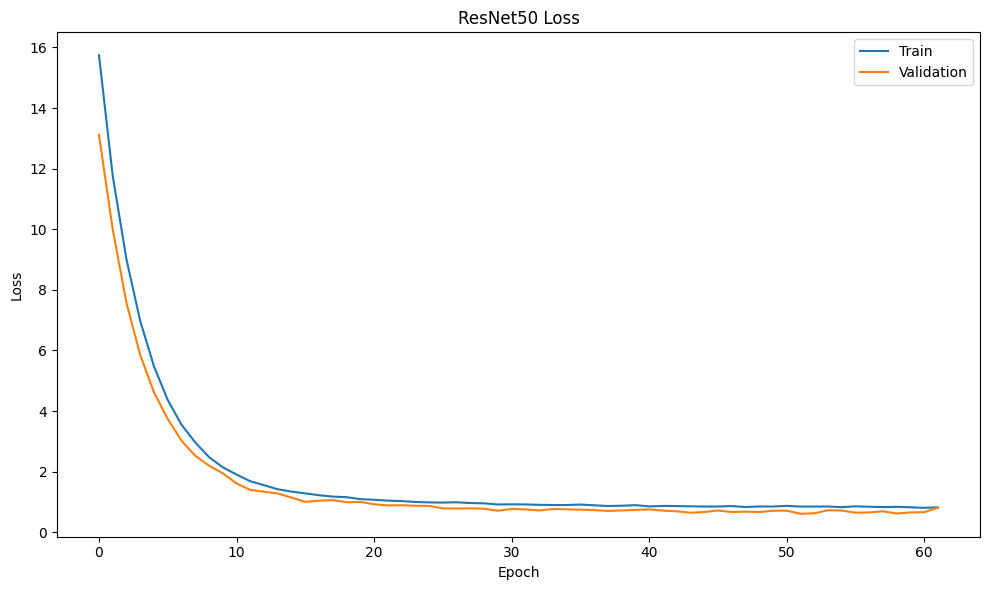

In [10]:
best_model, history, results = create_and_train_model(
    'ResNet50',
    (train_images, train_labels_one_hot),
    (val_images, val_labels_one_hot),
    (test_images, test_labels_one_hot)
)

### v) Display metrics

In [11]:
def display_metrics(best_model, train_data, val_data, test_data=None, history=None):

    def to_scalar(value):
        if hasattr(value, 'numpy'):
            value = value.numpy()

        if isinstance(value, np.ndarray):
            if value.size == 1:
                return value.item()
            else:
                return float(np.mean(value))

        return float(value)

    train_images, train_labels = train_data
    val_images, val_labels = val_data

    datasets = [
        ('Training', train_images, train_labels),
        ('Validation', val_images, val_labels)
    ]

    if test_data is not None:
        test_images, test_labels = test_data
        datasets.append(('Test', test_images, test_labels))

    all_metrics = {}

    print("\n" + "="*80)
    print(f"MODEL PERFORMANCE METRICS".center(80))
    print("="*80)

    header = f"{'Metric':<15}"
    for dataset_name, _, _ in datasets:
        header += f"{dataset_name:<25}"
    print(header)
    print("-"*80)

    for name, images, labels in datasets:
        print(f"Evaluating on {name} data...")

        batch_size = 5
        all_preds = []

        if len(labels.shape) > 1:
            true_classes = np.argmax(labels, axis=1)
        else:
            true_classes = labels

        for i in range(0, len(images), batch_size):
            batch_images = images[i:i+batch_size]
            batch_preds = best_model.predict(batch_images, verbose=0)
            all_preds.append(batch_preds)

        predictions = np.vstack(all_preds)
        pred_classes = np.argmax(predictions, axis=1)

        accuracy = to_scalar(accuracy_score(true_classes, pred_classes))
        precision = to_scalar(precision_score(true_classes, pred_classes, average='weighted', zero_division=0))
        recall = to_scalar(recall_score(true_classes, pred_classes, average='weighted', zero_division=0))
        f1 = to_scalar(f1_score(true_classes, pred_classes, average='weighted', zero_division=0))

        y_true_one_hot = labels if len(labels.shape) > 1 else tf.keras.utils.to_categorical(labels, num_classes=predictions.shape[1])
        auc = to_scalar(roc_auc_score(y_true_one_hot, predictions, average='weighted', multi_class='ovr'))

        evaluation = best_model.evaluate(images, labels, verbose=0)
        loss = to_scalar(evaluation[0])

        all_metrics[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'AUC': auc,
            'F1 Score': f1,
            'Loss': loss
        }

    metrics_to_display = ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1 Score']

    for metric in metrics_to_display:
        row = f"{metric:<15}"
        for dataset_name, _, _ in datasets:
            if dataset_name in all_metrics and metric in all_metrics[dataset_name]:
                value = all_metrics[dataset_name][metric]
                row += f"{value:.4f}".ljust(25)
            else:
                row += "N/A".ljust(25)
        print(row)

    print("="*80)

    if test_data is not None and 'Test' in all_metrics:
        print("\nDetailed Test Metrics:")
        test_results = all_metrics['Test']
        print(f"Test Loss: {test_results['Loss']:.4f}")
        print(f"Test Accuracy: {test_results['Accuracy']:.4f}")
        print(f"Test Precision: {test_results['Precision']:.4f}")
        print(f"Test F1 Score: {test_results['F1 Score']:.4f}")
        print(f"Test Recall: {test_results['Recall']:.4f}")
        print(f"Test AUC: {test_results['AUC']:.4f}")

        print("\nClassification Report on Test Data:")
        print(classification_report(true_classes, pred_classes))

    return all_metrics

In [12]:
metrics = display_metrics(
    best_model,
    (train_images, train_labels_one_hot),
    (val_images, val_labels_one_hot),
    (test_images, test_labels_one_hot),

)


                           MODEL PERFORMANCE METRICS                            
Metric         Training                 Validation               Test                     
--------------------------------------------------------------------------------
Evaluating on Training data...
Evaluating on Validation data...
Evaluating on Test data...
Accuracy       0.8989                   0.8934                   0.7631                   
Precision      0.9004                   0.8992                   0.7647                   
Recall         0.8989                   0.8934                   0.7631                   
AUC            0.9940                   0.9941                   0.9690                   
F1 Score       0.8981                   0.8922                   0.7572                   

Detailed Test Metrics:
Test Loss: 0.9691
Test Accuracy: 0.7631
Test Precision: 0.7647
Test F1 Score: 0.7572
Test Recall: 0.7631
Test AUC: 0.9690

Classification Report on Test Data:
              pre

### ResNet101

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,713,929 (166.76 MB)

 Trainable params: 1,054,729 (4.02 MB)

 Non-trainable params: 42,659,200 (162.73 MB)

Training with 760 steps per epoch
Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3990 - auc: 0.7800 - f1_score: 0.3846 - loss: 17.1260 - precision: 0.4946 - recall: 0.2894
Epoch 1: val_loss improved from inf to 12.98118, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 66s 58ms/step - accuracy: 0.3991 - auc: 0.7801 - f1_score: 0.3847 - loss: 17.1241 - precision: 0.4947 - recall: 0.2895 - val_accuracy: 0.7539 - val_auc: 0.9580 - val_f1_score: 0.7481 - val_loss: 12.9812 - val_precision: 0.8015 - val_recall: 0.7066
Epoch 2/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6256 - auc: 0.9250 - f1_score: 0.6219 - loss: 12.5074 - precision: 0.7001 - recall: 0.5280
Epoch 2: val_loss improved from 12.98118 to 9.90522, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.6256 - auc: 0.9250 - f1_score: 0.6219 - loss: 12.5055 - precision: 0.7001 - recall: 0.5280 - val_accuracy: 0.7987 - val_auc: 0.9749 - val_f1_score: 0.7879 - val_loss: 9.9052 - val_precision: 0.8458 - val_recall: 0.7579
Epoch 3/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7133 - auc: 0.9486 - f1_score: 0.7118 - loss: 9.5713 - precision: 0.7926 - recall: 0.6381
Epoch 3: val_loss improved from 9.90522 to 7.66427, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7133 - auc: 0.9486 - f1_score: 0.7118 - loss: 9.5698 - precision: 0.7926 - recall: 0.6381 - val_accuracy: 0.8158 - val_auc: 0.9759 - val_f1_score: 0.8048 - val_loss: 7.6643 - val_precision: 0.8524 - val_recall: 0.7750
Epoch 4/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7318 - auc: 0.9592 - f1_score: 0.7294 - loss: 7.4195 - precision: 0.8065 - recall: 0.6575
Epoch 4: val_loss improved from 7.66427 to 5.89852, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7318 - auc: 0.9592 - f1_score: 0.7294 - loss: 7.4184 - precision: 0.8065 - recall: 0.6575 - val_accuracy: 0.8197 - val_auc: 0.9851 - val_f1_score: 0.8151 - val_loss: 5.8985 - val_precision: 0.8571 - val_recall: 0.7974
Epoch 5/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7642 - auc: 0.9664 - f1_score: 0.7637 - loss: 5.7995 - precision: 0.8305 - recall: 0.6946
Epoch 5: val_loss improved from 5.89852 to 4.62840, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7642 - auc: 0.9664 - f1_score: 0.7637 - loss: 5.7987 - precision: 0.8305 - recall: 0.6946 - val_accuracy: 0.8421 - val_auc: 0.9861 - val_f1_score: 0.8451 - val_loss: 4.6284 - val_precision: 0.8791 - val_recall: 0.8039
Epoch 6/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7736 - auc: 0.9711 - f1_score: 0.7775 - loss: 4.6011 - precision: 0.8347 - recall: 0.7087
Epoch 6: val_loss improved from 4.62840 to 3.69916, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7736 - auc: 0.9710 - f1_score: 0.7775 - loss: 4.6006 - precision: 0.8347 - recall: 0.7087 - val_accuracy: 0.8461 - val_auc: 0.9879 - val_f1_score: 0.8472 - val_loss: 3.6992 - val_precision: 0.8750 - val_recall: 0.8105
Epoch 7/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7751 - auc: 0.9724 - f1_score: 0.7739 - loss: 3.7349 - precision: 0.8416 - recall: 0.7022
Epoch 7: val_loss improved from 3.69916 to 3.02090, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7750 - auc: 0.9724 - f1_score: 0.7739 - loss: 3.7345 - precision: 0.8416 - recall: 0.7022 - val_accuracy: 0.8539 - val_auc: 0.9883 - val_f1_score: 0.8581 - val_loss: 3.0209 - val_precision: 0.8782 - val_recall: 0.8158
Epoch 8/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7826 - auc: 0.9711 - f1_score: 0.7829 - loss: 3.1136 - precision: 0.8437 - recall: 0.7243
Epoch 8: val_loss improved from 3.02090 to 2.48601, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7826 - auc: 0.9711 - f1_score: 0.7829 - loss: 3.1133 - precision: 0.8437 - recall: 0.7243 - val_accuracy: 0.8671 - val_auc: 0.9882 - val_f1_score: 0.8748 - val_loss: 2.4860 - val_precision: 0.8925 - val_recall: 0.8408
Epoch 9/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7908 - auc: 0.9731 - f1_score: 0.7919 - loss: 2.6255 - precision: 0.8532 - recall: 0.7207
Epoch 9: val_loss improved from 2.48601 to 2.10500, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7907 - auc: 0.9731 - f1_score: 0.7919 - loss: 2.6253 - precision: 0.8532 - recall: 0.7207 - val_accuracy: 0.8711 - val_auc: 0.9890 - val_f1_score: 0.8767 - val_loss: 2.1050 - val_precision: 0.8983 - val_recall: 0.8368
Epoch 10/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7988 - auc: 0.9736 - f1_score: 0.7993 - loss: 2.2718 - precision: 0.8578 - recall: 0.7342
Epoch 10: val_loss improved from 2.10500 to 1.86565, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7988 - auc: 0.9736 - f1_score: 0.7992 - loss: 2.2717 - precision: 0.8578 - recall: 0.7342 - val_accuracy: 0.8579 - val_auc: 0.9870 - val_f1_score: 0.8625 - val_loss: 1.8656 - val_precision: 0.8938 - val_recall: 0.8303
Epoch 11/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8015 - auc: 0.9777 - f1_score: 0.8047 - loss: 1.9653 - precision: 0.8629 - recall: 0.7400
Epoch 11: val_loss improved from 1.86565 to 1.55406, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8015 - auc: 0.9777 - f1_score: 0.8047 - loss: 1.9652 - precision: 0.8629 - recall: 0.7400 - val_accuracy: 0.8789 - val_auc: 0.9926 - val_f1_score: 0.8834 - val_loss: 1.5541 - val_precision: 0.8986 - val_recall: 0.8513
Epoch 12/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8190 - auc: 0.9788 - f1_score: 0.8249 - loss: 1.7435 - precision: 0.8754 - recall: 0.7559
Epoch 12: val_loss improved from 1.55406 to 1.45028, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8189 - auc: 0.9788 - f1_score: 0.8248 - loss: 1.7435 - precision: 0.8754 - recall: 0.7558 - val_accuracy: 0.8763 - val_auc: 0.9897 - val_f1_score: 0.8793 - val_loss: 1.4503 - val_precision: 0.8939 - val_recall: 0.8421
Epoch 13/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7894 - auc: 0.9757 - f1_score: 0.7898 - loss: 1.6363 - precision: 0.8613 - recall: 0.7183
Epoch 13: val_loss improved from 1.45028 to 1.34026, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7894 - auc: 0.9757 - f1_score: 0.7898 - loss: 1.6363 - precision: 0.8612 - recall: 0.7183 - val_accuracy: 0.8513 - val_auc: 0.9883 - val_f1_score: 0.8476 - val_loss: 1.3403 - val_precision: 0.8875 - val_recall: 0.8303
Epoch 14/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8148 - auc: 0.9775 - f1_score: 0.8179 - loss: 1.4837 - precision: 0.8691 - recall: 0.7378
Epoch 14: val_loss improved from 1.34026 to 1.13763, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8148 - auc: 0.9775 - f1_score: 0.8179 - loss: 1.4837 - precision: 0.8691 - recall: 0.7378 - val_accuracy: 0.8908 - val_auc: 0.9938 - val_f1_score: 0.8967 - val_loss: 1.1376 - val_precision: 0.9280 - val_recall: 0.8645
Epoch 15/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8111 - auc: 0.9799 - f1_score: 0.8178 - loss: 1.3619 - precision: 0.8740 - recall: 0.7425
Epoch 15: val_loss did not improve from 1.13763
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.8111 - auc: 0.9799 - f1_score: 0.8178 - loss: 1.3619 - precision: 0.8740 - recall: 0.7425 - val_accuracy: 0.8539 - val_auc: 0.9885 - val_f1_score: 0.8610 - val_loss: 1.1443 - val_precision: 0.8864 - val_recall: 0.8316
Epoch 16/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8091 - auc: 0.9790 - f1_score: 0.8129 - loss: 1.2935 - precision: 0.8717 - recall: 0.7310
Epoch 16: val_loss improved from 1.13763 to 1.07118, saving model to ResNet101_best_

760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8091 - auc: 0.9790 - f1_score: 0.8129 - loss: 1.2935 - precision: 0.8717 - recall: 0.7310 - val_accuracy: 0.8474 - val_auc: 0.9898 - val_f1_score: 0.8492 - val_loss: 1.0712 - val_precision: 0.8769 - val_recall: 0.8158
Epoch 17/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8123 - auc: 0.9801 - f1_score: 0.8149 - loss: 1.2238 - precision: 0.8768 - recall: 0.7467
Epoch 17: val_loss improved from 1.07118 to 1.03028, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8122 - auc: 0.9801 - f1_score: 0.8149 - loss: 1.2239 - precision: 0.8768 - recall: 0.7467 - val_accuracy: 0.8579 - val_auc: 0.9873 - val_f1_score: 0.8626 - val_loss: 1.0303 - val_precision: 0.8883 - val_recall: 0.8158
Epoch 18/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8219 - auc: 0.9819 - f1_score: 0.8233 - loss: 1.1480 - precision: 0.8842 - recall: 0.7498
Epoch 18: val_loss improved from 1.03028 to 0.95590, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8218 - auc: 0.9819 - f1_score: 0.8233 - loss: 1.1481 - precision: 0.8842 - recall: 0.7497 - val_accuracy: 0.8711 - val_auc: 0.9913 - val_f1_score: 0.8754 - val_loss: 0.9559 - val_precision: 0.8938 - val_recall: 0.8303
Epoch 19/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8079 - auc: 0.9804 - f1_score: 0.8102 - loss: 1.1351 - precision: 0.8723 - recall: 0.7379
Epoch 19: val_loss improved from 0.95590 to 0.89800, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8079 - auc: 0.9804 - f1_score: 0.8102 - loss: 1.1351 - precision: 0.8723 - recall: 0.7379 - val_accuracy: 0.8776 - val_auc: 0.9921 - val_f1_score: 0.8786 - val_loss: 0.8980 - val_precision: 0.9070 - val_recall: 0.8474
Epoch 20/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8079 - auc: 0.9778 - f1_score: 0.8112 - loss: 1.1264 - precision: 0.8648 - recall: 0.7290
Epoch 20: val_loss improved from 0.89800 to 0.89504, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8078 - auc: 0.9778 - f1_score: 0.8112 - loss: 1.1264 - precision: 0.8648 - recall: 0.7289 - val_accuracy: 0.8697 - val_auc: 0.9898 - val_f1_score: 0.8679 - val_loss: 0.8950 - val_precision: 0.9017 - val_recall: 0.8329
Epoch 21/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7982 - auc: 0.9773 - f1_score: 0.8058 - loss: 1.1165 - precision: 0.8765 - recall: 0.7163
Epoch 21: val_loss improved from 0.89504 to 0.87054, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7982 - auc: 0.9773 - f1_score: 0.8058 - loss: 1.1165 - precision: 0.8765 - recall: 0.7163 - val_accuracy: 0.8566 - val_auc: 0.9906 - val_f1_score: 0.8619 - val_loss: 0.8705 - val_precision: 0.8779 - val_recall: 0.8329
Epoch 22/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8189 - auc: 0.9812 - f1_score: 0.8240 - loss: 1.0316 - precision: 0.8762 - recall: 0.7501
Epoch 22: val_loss improved from 0.87054 to 0.80794, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.8189 - auc: 0.9812 - f1_score: 0.8240 - loss: 1.0317 - precision: 0.8762 - recall: 0.7501 - val_accuracy: 0.8842 - val_auc: 0.9921 - val_f1_score: 0.8890 - val_loss: 0.8079 - val_precision: 0.9151 - val_recall: 0.8513
Epoch 23/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8246 - auc: 0.9822 - f1_score: 0.8299 - loss: 0.9980 - precision: 0.8882 - recall: 0.7574
Epoch 23: val_loss did not improve from 0.80794
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.8246 - auc: 0.9822 - f1_score: 0.8299 - loss: 0.9980 - precision: 0.8882 - recall: 0.7574 - val_accuracy: 0.8566 - val_auc: 0.9905 - val_f1_score: 0.8656 - val_loss: 0.8373 - val_precision: 0.8883 - val_recall: 0.8263
Epoch 24/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8170 - auc: 0.9787 - f1_score: 0.8167 - loss: 1.0261 - precision: 0.8717 - recall: 0.7288
Epoch 24: val_loss improved from 0.80794 to 0.78702, saving model to ResNet101_best_

760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8170 - auc: 0.9787 - f1_score: 0.8167 - loss: 1.0261 - precision: 0.8718 - recall: 0.7288 - val_accuracy: 0.8789 - val_auc: 0.9922 - val_f1_score: 0.8846 - val_loss: 0.7870 - val_precision: 0.9063 - val_recall: 0.8526
Epoch 25/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8203 - auc: 0.9825 - f1_score: 0.8232 - loss: 0.9721 - precision: 0.8801 - recall: 0.7539
Epoch 25: val_loss improved from 0.78702 to 0.77708, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.8203 - auc: 0.9825 - f1_score: 0.8232 - loss: 0.9722 - precision: 0.8801 - recall: 0.7538 - val_accuracy: 0.8816 - val_auc: 0.9923 - val_f1_score: 0.8907 - val_loss: 0.7771 - val_precision: 0.9134 - val_recall: 0.8461
Epoch 26/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8239 - auc: 0.9833 - f1_score: 0.8272 - loss: 0.9478 - precision: 0.8878 - recall: 0.7564
Epoch 26: val_loss improved from 0.77708 to 0.77708, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8239 - auc: 0.9833 - f1_score: 0.8272 - loss: 0.9479 - precision: 0.8877 - recall: 0.7563 - val_accuracy: 0.8737 - val_auc: 0.9898 - val_f1_score: 0.8781 - val_loss: 0.7771 - val_precision: 0.9006 - val_recall: 0.8342
Epoch 27/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8317 - auc: 0.9826 - f1_score: 0.8406 - loss: 0.9285 - precision: 0.8920 - recall: 0.7640
Epoch 27: val_loss improved from 0.77708 to 0.76310, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8317 - auc: 0.9826 - f1_score: 0.8406 - loss: 0.9286 - precision: 0.8920 - recall: 0.7640 - val_accuracy: 0.8737 - val_auc: 0.9911 - val_f1_score: 0.8791 - val_loss: 0.7631 - val_precision: 0.9199 - val_recall: 0.8461
Epoch 28/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8122 - auc: 0.9813 - f1_score: 0.8171 - loss: 0.9501 - precision: 0.8780 - recall: 0.7527
Epoch 28: val_loss improved from 0.76310 to 0.76232, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.8122 - auc: 0.9813 - f1_score: 0.8171 - loss: 0.9501 - precision: 0.8780 - recall: 0.7527 - val_accuracy: 0.8632 - val_auc: 0.9906 - val_f1_score: 0.8660 - val_loss: 0.7623 - val_precision: 0.8997 - val_recall: 0.8263
Epoch 29/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8111 - auc: 0.9780 - f1_score: 0.8118 - loss: 0.9767 - precision: 0.8775 - recall: 0.7356
Epoch 29: val_loss improved from 0.76232 to 0.72180, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8111 - auc: 0.9780 - f1_score: 0.8118 - loss: 0.9767 - precision: 0.8774 - recall: 0.7356 - val_accuracy: 0.8789 - val_auc: 0.9933 - val_f1_score: 0.8785 - val_loss: 0.7218 - val_precision: 0.9150 - val_recall: 0.8500
Epoch 30/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8296 - auc: 0.9812 - f1_score: 0.8299 - loss: 0.9380 - precision: 0.8948 - recall: 0.7442
Epoch 30: val_loss improved from 0.72180 to 0.71847, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8296 - auc: 0.9812 - f1_score: 0.8299 - loss: 0.9381 - precision: 0.8948 - recall: 0.7442 - val_accuracy: 0.8789 - val_auc: 0.9925 - val_f1_score: 0.8832 - val_loss: 0.7185 - val_precision: 0.9147 - val_recall: 0.8461
Epoch 31/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8043 - auc: 0.9802 - f1_score: 0.8082 - loss: 0.9527 - precision: 0.8848 - recall: 0.7329
Epoch 31: val_loss did not improve from 0.71847
760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8043 - auc: 0.9802 - f1_score: 0.8082 - loss: 0.9527 - precision: 0.8848 - recall: 0.7329 - val_accuracy: 0.8697 - val_auc: 0.9913 - val_f1_score: 0.8774 - val_loss: 0.7311 - val_precision: 0.8999 - val_recall: 0.8395
Epoch 32/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8141 - auc: 0.9825 - f1_score: 0.8181 - loss: 0.9072 - precision: 0.8813 - recall: 0.7431
Epoch 32: val_loss improved from 0.71847 to 0.69352, saving model to ResNet101_best_

760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8141 - auc: 0.9825 - f1_score: 0.8181 - loss: 0.9073 - precision: 0.8813 - recall: 0.7430 - val_accuracy: 0.8803 - val_auc: 0.9926 - val_f1_score: 0.8875 - val_loss: 0.6935 - val_precision: 0.9208 - val_recall: 0.8566
Epoch 33/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8264 - auc: 0.9814 - f1_score: 0.8288 - loss: 0.9072 - precision: 0.8895 - recall: 0.7475
Epoch 33: val_loss improved from 0.69352 to 0.68412, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.8264 - auc: 0.9814 - f1_score: 0.8288 - loss: 0.9072 - precision: 0.8895 - recall: 0.7475 - val_accuracy: 0.8763 - val_auc: 0.9926 - val_f1_score: 0.8773 - val_loss: 0.6841 - val_precision: 0.9110 - val_recall: 0.8618
Epoch 34/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8271 - auc: 0.9812 - f1_score: 0.8307 - loss: 0.8928 - precision: 0.8841 - recall: 0.7671
Epoch 34: val_loss improved from 0.68412 to 0.65498, saving model to ResNet101_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.8271 - auc: 0.9812 - f1_score: 0.8307 - loss: 0.8929 - precision: 0.8840 - recall: 0.7670 - val_accuracy: 0.8987 - val_auc: 0.9938 - val_f1_score: 0.9007 - val_loss: 0.6550 - val_precision: 0.9244 - val_recall: 0.8684
Epoch 35/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8181 - auc: 0.9820 - f1_score: 0.8231 - loss: 0.8927 - precision: 0.8819 - recall: 0.7507
Epoch 35: val_loss did not improve from 0.65498
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.8180 - auc: 0.9820 - f1_score: 0.8231 - loss: 0.8928 - precision: 0.8819 - recall: 0.7507 - val_accuracy: 0.8763 - val_auc: 0.9938 - val_f1_score: 0.8762 - val_loss: 0.6715 - val_precision: 0.9082 - val_recall: 0.8461
Epoch 36/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8204 - auc: 0.9803 - f1_score: 0.8302 - loss: 0.9078 - precision: 0.8795 - recall: 0.7371
Epoch 36: val_loss did not improve from 0.65498
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39m

760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8358 - auc: 0.9832 - f1_score: 0.8411 - loss: 0.8533 - precision: 0.8893 - recall: 0.7619 - val_accuracy: 0.8908 - val_auc: 0.9946 - val_f1_score: 0.8940 - val_loss: 0.6364 - val_precision: 0.9207 - val_recall: 0.8553
Epoch 42/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8353 - auc: 0.9820 - f1_score: 0.8377 - loss: 0.8540 - precision: 0.8916 - recall: 0.7686
Epoch 42: val_loss did not improve from 0.63641
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.8353 - auc: 0.9820 - f1_score: 0.8377 - loss: 0.8541 - precision: 0.8915 - recall: 0.7686 - val_accuracy: 0.8829 - val_auc: 0.9937 - val_f1_score: 0.8853 - val_loss: 0.6499 - val_precision: 0.9123 - val_recall: 0.8487
Epoch 43/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8256 - auc: 0.9832 - f1_score: 0.8272 - loss: 0.8597 - precision: 0.8851 - recall: 0.7425
Epoch 43: val_loss did not improve from 0.63641
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39m

760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8250 - auc: 0.9805 - f1_score: 0.8261 - loss: 0.8659 - precision: 0.8881 - recall: 0.7468 - val_accuracy: 0.8961 - val_auc: 0.9950 - val_f1_score: 0.9008 - val_loss: 0.5997 - val_precision: 0.9236 - val_recall: 0.8750
Epoch 49/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8378 - auc: 0.9834 - f1_score: 0.8414 - loss: 0.8251 - precision: 0.8917 - recall: 0.7686
Epoch 49: val_loss did not improve from 0.59971
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.8378 - auc: 0.9834 - f1_score: 0.8413 - loss: 0.8251 - precision: 0.8917 - recall: 0.7686 - val_accuracy: 0.8776 - val_auc: 0.9928 - val_f1_score: 0.8845 - val_loss: 0.6457 - val_precision: 0.9099 - val_recall: 0.8500
Epoch 50/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8319 - auc: 0.9808 - f1_score: 0.8366 - loss: 0.8489 - precision: 0.8980 - recall: 0.7635
Epoch 50: val_loss improved from 0.59971 to 0.59504, saving model to ResNet101_best_

760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8319 - auc: 0.9808 - f1_score: 0.8366 - loss: 0.8488 - precision: 0.8980 - recall: 0.7635 - val_accuracy: 0.9092 - val_auc: 0.9952 - val_f1_score: 0.9155 - val_loss: 0.5950 - val_precision: 0.9261 - val_recall: 0.8737
Epoch 51/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8320 - auc: 0.9833 - f1_score: 0.8390 - loss: 0.8267 - precision: 0.8918 - recall: 0.7655
Epoch 51: val_loss did not improve from 0.59504
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.8319 - auc: 0.9833 - f1_score: 0.8389 - loss: 0.8267 - precision: 0.8918 - recall: 0.7655 - val_accuracy: 0.8789 - val_auc: 0.9932 - val_f1_score: 0.8834 - val_loss: 0.6436 - val_precision: 0.9137 - val_recall: 0.8500
Epoch 52/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8249 - auc: 0.9817 - f1_score: 0.8309 - loss: 0.8556 - precision: 0.8920 - recall: 0.7578
Epoch 52: val_loss did not improve from 0.59504
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39m

760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8373 - auc: 0.9850 - f1_score: 0.8381 - loss: 0.8034 - precision: 0.8945 - recall: 0.7572 - val_accuracy: 0.9132 - val_auc: 0.9957 - val_f1_score: 0.9177 - val_loss: 0.5706 - val_precision: 0.9356 - val_recall: 0.8789
Epoch 59/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8365 - auc: 0.9834 - f1_score: 0.8449 - loss: 0.8076 - precision: 0.8853 - recall: 0.7731
Epoch 59: val_loss did not improve from 0.57059
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.8365 - auc: 0.9834 - f1_score: 0.8449 - loss: 0.8076 - precision: 0.8853 - recall: 0.7731 - val_accuracy: 0.8934 - val_auc: 0.9940 - val_f1_score: 0.8966 - val_loss: 0.6068 - val_precision: 0.9139 - val_recall: 0.8658
Epoch 60/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8272 - auc: 0.9836 - f1_score: 0.8322 - loss: 0.8146 - precision: 0.8917 - recall: 0.7616
Epoch 60: val_loss did not improve from 0.57059
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39m

760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8282 - auc: 0.9835 - f1_score: 0.8325 - loss: 0.8153 - precision: 0.8932 - recall: 0.7626 - val_accuracy: 0.9105 - val_auc: 0.9963 - val_f1_score: 0.9155 - val_loss: 0.5557 - val_precision: 0.9330 - val_recall: 0.8789
Epoch 65/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8302 - auc: 0.9851 - f1_score: 0.8307 - loss: 0.7872 - precision: 0.8912 - recall: 0.7718
Epoch 65: val_loss did not improve from 0.55571
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.8302 - auc: 0.9851 - f1_score: 0.8307 - loss: 0.7873 - precision: 0.8912 - recall: 0.7717 - val_accuracy: 0.8737 - val_auc: 0.9932 - val_f1_score: 0.8791 - val_loss: 0.6202 - val_precision: 0.9021 - val_recall: 0.8368
Epoch 66/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8358 - auc: 0.9844 - f1_score: 0.8414 - loss: 0.7976 - precision: 0.8904 - recall: 0.7704
Epoch 66: val_loss did not improve from 0.55571
760/760 ━━━━━━━━━━━━━━━━━━━━ 30s 39m

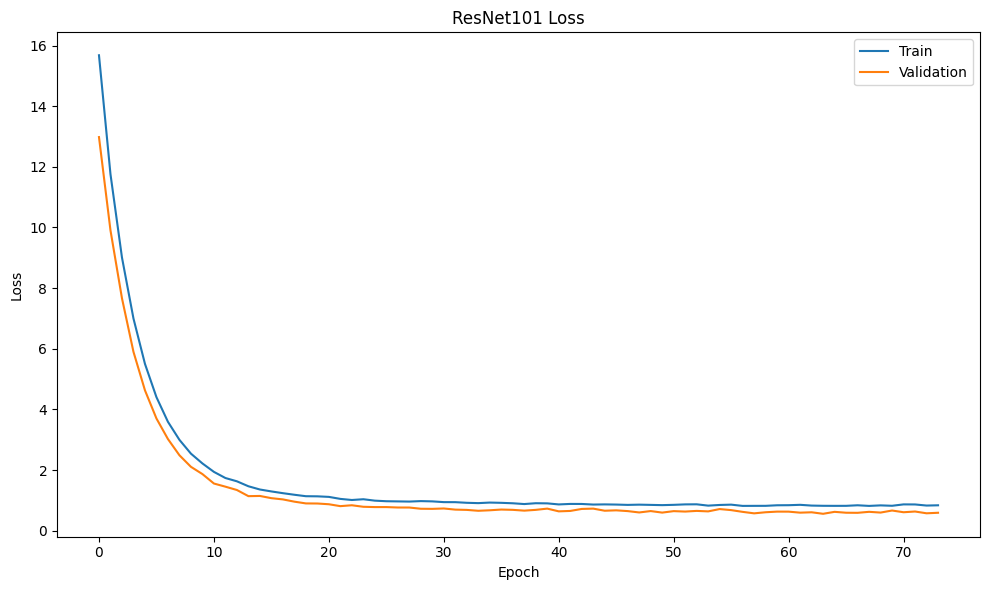

In [13]:
best_model, history, results = create_and_train_model(
    'ResNet101',
    (train_images, train_labels_one_hot),
    (val_images, val_labels_one_hot),
    (test_images, test_labels_one_hot)
)

### v) Display metrics

In [14]:
metrics = display_metrics(
    best_model,
    (train_images, train_labels_one_hot),
    (val_images, val_labels_one_hot),
    (test_images, test_labels_one_hot),

)


                           MODEL PERFORMANCE METRICS                            
Metric         Training                 Validation               Test                     
--------------------------------------------------------------------------------
Evaluating on Training data...
Evaluating on Validation data...
Evaluating on Test data...
Accuracy       0.9194                   0.9105                   0.7642                   
Precision      0.9204                   0.9123                   0.7678                   
Recall         0.9194                   0.9105                   0.7642                   
AUC            0.9955                   0.9956                   0.9683                   
F1 Score       0.9191                   0.9099                   0.7523                   

Detailed Test Metrics:
Test Loss: 0.9812
Test Accuracy: 0.7642
Test Precision: 0.7678
Test F1 Score: 0.7523
Test Recall: 0.7642
Test AUC: 0.9683

Classification Report on Test Data:
              pre

### EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,712,108 (17.98 MB)

 Trainable params: 661,513 (2.52 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

Training with 760 steps per epoch
Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3632 - auc: 0.7535 - f1_score: 0.3483 - loss: 16.3147 - precision: 0.4412 - recall: 0.2489
Epoch 1: val_loss improved from inf to 12.93329, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 53s 39ms/step - accuracy: 0.3633 - auc: 0.7536 - f1_score: 0.3484 - loss: 16.3131 - precision: 0.4414 - recall: 0.2491 - val_accuracy: 0.7658 - val_auc: 0.9664 - val_f1_score: 0.7646 - val_loss: 12.9333 - val_precision: 0.8161 - val_recall: 0.7184
Epoch 2/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6656 - auc: 0.9334 - f1_score: 0.6572 - loss: 12.6091 - precision: 0.7575 - recall: 0.5896
Epoch 2: val_loss improved from 12.93329 to 10.30092, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6657 - auc: 0.9334 - f1_score: 0.6573 - loss: 12.6058 - precision: 0.7575 - recall: 0.5897 - val_accuracy: 0.8329 - val_auc: 0.9819 - val_f1_score: 0.8333 - val_loss: 10.3009 - val_precision: 0.8725 - val_recall: 0.8013
Epoch 3/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7237 - auc: 0.9589 - f1_score: 0.7203 - loss: 10.0587 - precision: 0.7981 - recall: 0.6590
Epoch 3: val_loss improved from 10.30092 to 8.21102, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7238 - auc: 0.9588 - f1_score: 0.7203 - loss: 10.0555 - precision: 0.7981 - recall: 0.6591 - val_accuracy: 0.8658 - val_auc: 0.9843 - val_f1_score: 0.8619 - val_loss: 8.2110 - val_precision: 0.8976 - val_recall: 0.8421
Epoch 4/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7802 - auc: 0.9670 - f1_score: 0.7806 - loss: 8.0302 - precision: 0.8301 - recall: 0.7202
Epoch 4: val_loss improved from 8.21102 to 6.50746, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7801 - auc: 0.9670 - f1_score: 0.7805 - loss: 8.0281 - precision: 0.8301 - recall: 0.7201 - val_accuracy: 0.8763 - val_auc: 0.9899 - val_f1_score: 0.8774 - val_loss: 6.5075 - val_precision: 0.8990 - val_recall: 0.8553
Epoch 5/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7837 - auc: 0.9741 - f1_score: 0.7903 - loss: 6.4212 - precision: 0.8421 - recall: 0.7273
Epoch 5: val_loss improved from 6.50746 to 5.14852, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7837 - auc: 0.9740 - f1_score: 0.7903 - loss: 6.4196 - precision: 0.8421 - recall: 0.7273 - val_accuracy: 0.9079 - val_auc: 0.9928 - val_f1_score: 0.9064 - val_loss: 5.1485 - val_precision: 0.9246 - val_recall: 0.8868
Epoch 6/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8140 - auc: 0.9774 - f1_score: 0.8152 - loss: 5.1720 - precision: 0.8624 - recall: 0.7549
Epoch 6: val_loss improved from 5.14852 to 4.15175, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8140 - auc: 0.9774 - f1_score: 0.8152 - loss: 5.1708 - precision: 0.8623 - recall: 0.7548 - val_accuracy: 0.9132 - val_auc: 0.9938 - val_f1_score: 0.9151 - val_loss: 4.1517 - val_precision: 0.9300 - val_recall: 0.8921
Epoch 7/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8112 - auc: 0.9786 - f1_score: 0.8071 - loss: 4.2237 - precision: 0.8679 - recall: 0.7676
Epoch 7: val_loss improved from 4.15175 to 3.42220, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8112 - auc: 0.9786 - f1_score: 0.8071 - loss: 4.2225 - precision: 0.8678 - recall: 0.7675 - val_accuracy: 0.9000 - val_auc: 0.9903 - val_f1_score: 0.9013 - val_loss: 3.4222 - val_precision: 0.9159 - val_recall: 0.8882
Epoch 8/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8239 - auc: 0.9795 - f1_score: 0.8273 - loss: 3.4830 - precision: 0.8774 - recall: 0.7781
Epoch 8: val_loss improved from 3.42220 to 2.81311, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8239 - auc: 0.9795 - f1_score: 0.8273 - loss: 3.4828 - precision: 0.8774 - recall: 0.7781 - val_accuracy: 0.9053 - val_auc: 0.9912 - val_f1_score: 0.9064 - val_loss: 2.8131 - val_precision: 0.9240 - val_recall: 0.8961
Epoch 9/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8387 - auc: 0.9834 - f1_score: 0.8400 - loss: 2.8945 - precision: 0.8833 - recall: 0.7900
Epoch 9: val_loss improved from 2.81311 to 2.31743, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8387 - auc: 0.9834 - f1_score: 0.8400 - loss: 2.8938 - precision: 0.8833 - recall: 0.7899 - val_accuracy: 0.9224 - val_auc: 0.9950 - val_f1_score: 0.9230 - val_loss: 2.3174 - val_precision: 0.9351 - val_recall: 0.9105
Epoch 10/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8404 - auc: 0.9823 - f1_score: 0.8419 - loss: 2.4896 - precision: 0.8900 - recall: 0.7854
Epoch 10: val_loss improved from 2.31743 to 1.96477, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8404 - auc: 0.9823 - f1_score: 0.8419 - loss: 2.4895 - precision: 0.8899 - recall: 0.7854 - val_accuracy: 0.9289 - val_auc: 0.9954 - val_f1_score: 0.9289 - val_loss: 1.9648 - val_precision: 0.9393 - val_recall: 0.9158
Epoch 11/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8521 - auc: 0.9856 - f1_score: 0.8546 - loss: 2.1297 - precision: 0.9004 - recall: 0.8028
Epoch 11: val_loss improved from 1.96477 to 1.66432, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8520 - auc: 0.9856 - f1_score: 0.8546 - loss: 2.1296 - precision: 0.9003 - recall: 0.8028 - val_accuracy: 0.9408 - val_auc: 0.9967 - val_f1_score: 0.9432 - val_loss: 1.6643 - val_precision: 0.9526 - val_recall: 0.9250
Epoch 12/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8505 - auc: 0.9869 - f1_score: 0.8514 - loss: 1.8643 - precision: 0.8964 - recall: 0.7962
Epoch 12: val_loss improved from 1.66432 to 1.46036, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8505 - auc: 0.9869 - f1_score: 0.8514 - loss: 1.8641 - precision: 0.8964 - recall: 0.7962 - val_accuracy: 0.9421 - val_auc: 0.9963 - val_f1_score: 0.9431 - val_loss: 1.4604 - val_precision: 0.9526 - val_recall: 0.9250
Epoch 13/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8465 - auc: 0.9854 - f1_score: 0.8506 - loss: 1.6921 - precision: 0.8883 - recall: 0.7836
Epoch 13: val_loss improved from 1.46036 to 1.29958, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8465 - auc: 0.9854 - f1_score: 0.8506 - loss: 1.6919 - precision: 0.8884 - recall: 0.7836 - val_accuracy: 0.9368 - val_auc: 0.9956 - val_f1_score: 0.9380 - val_loss: 1.2996 - val_precision: 0.9499 - val_recall: 0.9237
Epoch 14/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8567 - auc: 0.9855 - f1_score: 0.8557 - loss: 1.5195 - precision: 0.9067 - recall: 0.8120
Epoch 14: val_loss improved from 1.29958 to 1.16599, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8566 - auc: 0.9855 - f1_score: 0.8557 - loss: 1.5195 - precision: 0.9067 - recall: 0.8120 - val_accuracy: 0.9316 - val_auc: 0.9961 - val_f1_score: 0.9322 - val_loss: 1.1660 - val_precision: 0.9424 - val_recall: 0.9263
Epoch 15/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8616 - auc: 0.9872 - f1_score: 0.8632 - loss: 1.3787 - precision: 0.9074 - recall: 0.8045
Epoch 15: val_loss improved from 1.16599 to 1.04829, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8616 - auc: 0.9872 - f1_score: 0.8632 - loss: 1.3787 - precision: 0.9074 - recall: 0.8045 - val_accuracy: 0.9474 - val_auc: 0.9976 - val_f1_score: 0.9481 - val_loss: 1.0483 - val_precision: 0.9558 - val_recall: 0.9395
Epoch 16/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8609 - auc: 0.9877 - f1_score: 0.8671 - loss: 1.2714 - precision: 0.9064 - recall: 0.8151
Epoch 16: val_loss improved from 1.04829 to 0.95222, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8609 - auc: 0.9877 - f1_score: 0.8671 - loss: 1.2714 - precision: 0.9063 - recall: 0.8151 - val_accuracy: 0.9487 - val_auc: 0.9981 - val_f1_score: 0.9501 - val_loss: 0.9522 - val_precision: 0.9622 - val_recall: 0.9382
Epoch 17/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8558 - auc: 0.9870 - f1_score: 0.8586 - loss: 1.2133 - precision: 0.9011 - recall: 0.8031
Epoch 17: val_loss improved from 0.95222 to 0.93733, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8558 - auc: 0.9870 - f1_score: 0.8586 - loss: 1.2132 - precision: 0.9011 - recall: 0.8031 - val_accuracy: 0.9303 - val_auc: 0.9955 - val_f1_score: 0.9329 - val_loss: 0.9373 - val_precision: 0.9472 - val_recall: 0.9197
Epoch 18/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8462 - auc: 0.9865 - f1_score: 0.8502 - loss: 1.1604 - precision: 0.8982 - recall: 0.7992
Epoch 18: val_loss improved from 0.93733 to 0.86793, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8462 - auc: 0.9865 - f1_score: 0.8501 - loss: 1.1605 - precision: 0.8982 - recall: 0.7992 - val_accuracy: 0.9434 - val_auc: 0.9965 - val_f1_score: 0.9445 - val_loss: 0.8679 - val_precision: 0.9540 - val_recall: 0.9276
Epoch 19/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8422 - auc: 0.9865 - f1_score: 0.8408 - loss: 1.1187 - precision: 0.8901 - recall: 0.7934
Epoch 19: val_loss improved from 0.86793 to 0.82353, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8422 - auc: 0.9865 - f1_score: 0.8408 - loss: 1.1187 - precision: 0.8901 - recall: 0.7934 - val_accuracy: 0.9368 - val_auc: 0.9956 - val_f1_score: 0.9420 - val_loss: 0.8235 - val_precision: 0.9539 - val_recall: 0.9250
Epoch 20/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8689 - auc: 0.9890 - f1_score: 0.8712 - loss: 1.0252 - precision: 0.9108 - recall: 0.8189
Epoch 20: val_loss improved from 0.82353 to 0.76708, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8689 - auc: 0.9890 - f1_score: 0.8712 - loss: 1.0253 - precision: 0.9108 - recall: 0.8189 - val_accuracy: 0.9487 - val_auc: 0.9974 - val_f1_score: 0.9507 - val_loss: 0.7671 - val_precision: 0.9594 - val_recall: 0.9329
Epoch 21/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8658 - auc: 0.9884 - f1_score: 0.8698 - loss: 1.0077 - precision: 0.9074 - recall: 0.8150
Epoch 21: val_loss improved from 0.76708 to 0.73571, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8658 - auc: 0.9884 - f1_score: 0.8698 - loss: 1.0077 - precision: 0.9073 - recall: 0.8149 - val_accuracy: 0.9474 - val_auc: 0.9960 - val_f1_score: 0.9497 - val_loss: 0.7357 - val_precision: 0.9609 - val_recall: 0.9382
Epoch 22/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8730 - auc: 0.9902 - f1_score: 0.8736 - loss: 0.9528 - precision: 0.9195 - recall: 0.8224
Epoch 22: val_loss improved from 0.73571 to 0.71994, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8730 - auc: 0.9902 - f1_score: 0.8736 - loss: 0.9529 - precision: 0.9195 - recall: 0.8224 - val_accuracy: 0.9355 - val_auc: 0.9975 - val_f1_score: 0.9376 - val_loss: 0.7199 - val_precision: 0.9540 - val_recall: 0.9276
Epoch 23/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8523 - auc: 0.9886 - f1_score: 0.8561 - loss: 0.9617 - precision: 0.9026 - recall: 0.8015
Epoch 23: val_loss improved from 0.71994 to 0.70845, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8523 - auc: 0.9886 - f1_score: 0.8561 - loss: 0.9617 - precision: 0.9026 - recall: 0.8015 - val_accuracy: 0.9421 - val_auc: 0.9953 - val_f1_score: 0.9461 - val_loss: 0.7084 - val_precision: 0.9480 - val_recall: 0.9355
Epoch 24/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8635 - auc: 0.9883 - f1_score: 0.8665 - loss: 0.9258 - precision: 0.9026 - recall: 0.8193
Epoch 24: val_loss improved from 0.70845 to 0.68261, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8634 - auc: 0.9883 - f1_score: 0.8665 - loss: 0.9259 - precision: 0.9025 - recall: 0.8192 - val_accuracy: 0.9316 - val_auc: 0.9973 - val_f1_score: 0.9319 - val_loss: 0.6826 - val_precision: 0.9459 - val_recall: 0.9211
Epoch 25/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8568 - auc: 0.9857 - f1_score: 0.8591 - loss: 0.9476 - precision: 0.8998 - recall: 0.8046
Epoch 25: val_loss improved from 0.68261 to 0.65792, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8568 - auc: 0.9857 - f1_score: 0.8591 - loss: 0.9476 - precision: 0.8998 - recall: 0.8046 - val_accuracy: 0.9395 - val_auc: 0.9967 - val_f1_score: 0.9406 - val_loss: 0.6579 - val_precision: 0.9530 - val_recall: 0.9329
Epoch 26/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8666 - auc: 0.9890 - f1_score: 0.8678 - loss: 0.8980 - precision: 0.9112 - recall: 0.8143
Epoch 26: val_loss did not improve from 0.65792
760/760 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8665 - auc: 0.9890 - f1_score: 0.8678 - loss: 0.8980 - precision: 0.9112 - recall: 0.8143 - val_accuracy: 0.9355 - val_auc: 0.9943 - val_f1_score: 0.9369 - val_loss: 0.6848 - val_precision: 0.9500 - val_recall: 0.9250
Epoch 27/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8512 - auc: 0.9873 - f1_score: 0.8587 - loss: 0.9075 - precision: 0.8949 - recall: 0.8054
Epoch 27: val_loss did not improve from 0.65792
760/760 ━━━━━━━━━━━━━━━━━━━━ 14s 18m

760/760 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8652 - auc: 0.9902 - f1_score: 0.8677 - loss: 0.8492 - precision: 0.9108 - recall: 0.8267 - val_accuracy: 0.9382 - val_auc: 0.9961 - val_f1_score: 0.9402 - val_loss: 0.6456 - val_precision: 0.9468 - val_recall: 0.9132
Epoch 29/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8684 - auc: 0.9894 - f1_score: 0.8685 - loss: 0.8503 - precision: 0.9139 - recall: 0.8240
Epoch 29: val_loss improved from 0.64562 to 0.61543, saving model to EfficientNetB0_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8684 - auc: 0.9894 - f1_score: 0.8685 - loss: 0.8503 - precision: 0.9139 - recall: 0.8239 - val_accuracy: 0.9408 - val_auc: 0.9974 - val_f1_score: 0.9399 - val_loss: 0.6154 - val_precision: 0.9528 - val_recall: 0.9303
Epoch 30/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8756 - auc: 0.9903 - f1_score: 0.8790 - loss: 0.8382 - precision: 0.9179 - recall: 0.8237
Epoch 30: val_loss did not improve from 0.61543
760/760 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8756 - auc: 0.9903 - f1_score: 0.8790 - loss: 0.8382 - precision: 0.9178 - recall: 0.8237 - val_accuracy: 0.9342 - val_auc: 0.9949 - val_f1_score: 0.9370 - val_loss: 0.6269 - val_precision: 0.9489 - val_recall: 0.9289
Epoch 31/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8704 - auc: 0.9880 - f1_score: 0.8734 - loss: 0.8444 - precision: 0.9143 - recall: 0.8208
Epoch 31: val_loss did not improve from 0.61543
760/760 ━━━━━━━━━━━━━━━━━━━━ 14s 19m

760/760 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8736 - auc: 0.9894 - f1_score: 0.8742 - loss: 0.8347 - precision: 0.9175 - recall: 0.8224 - val_accuracy: 0.9368 - val_auc: 0.9964 - val_f1_score: 0.9390 - val_loss: 0.6123 - val_precision: 0.9514 - val_recall: 0.9276
Epoch 33/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8621 - auc: 0.9878 - f1_score: 0.8633 - loss: 0.8614 - precision: 0.9006 - recall: 0.8096
Epoch 33: val_loss did not improve from 0.61234
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8620 - auc: 0.9878 - f1_score: 0.8633 - loss: 0.8615 - precision: 0.9006 - recall: 0.8096 - val_accuracy: 0.9382 - val_auc: 0.9968 - val_f1_score: 0.9395 - val_loss: 0.6191 - val_precision: 0.9526 - val_recall: 0.9263
Epoch 34/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8587 - auc: 0.9884 - f1_score: 0.8621 - loss: 0.8494 - precision: 0.9056 - recall: 0.8104
Epoch 34: val_loss improved from 0.61234 to 0.59143, saving model to EfficientNetB0_

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8587 - auc: 0.9884 - f1_score: 0.8621 - loss: 0.8494 - precision: 0.9056 - recall: 0.8103 - val_accuracy: 0.9434 - val_auc: 0.9980 - val_f1_score: 0.9414 - val_loss: 0.5914 - val_precision: 0.9553 - val_recall: 0.9289
Epoch 35/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8587 - auc: 0.9876 - f1_score: 0.8621 - loss: 0.8463 - precision: 0.9043 - recall: 0.8103
Epoch 35: val_loss did not improve from 0.59143
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8588 - auc: 0.9876 - f1_score: 0.8621 - loss: 0.8463 - precision: 0.9043 - recall: 0.8103 - val_accuracy: 0.9355 - val_auc: 0.9969 - val_f1_score: 0.9384 - val_loss: 0.6047 - val_precision: 0.9472 - val_recall: 0.9197
Epoch 36/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8635 - auc: 0.9890 - f1_score: 0.8645 - loss: 0.8389 - precision: 0.9015 - recall: 0.8123
Epoch 36: val_loss improved from 0.59143 to 0.57590, saving model to EfficientNetB0_

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8635 - auc: 0.9890 - f1_score: 0.8645 - loss: 0.8389 - precision: 0.9015 - recall: 0.8123 - val_accuracy: 0.9474 - val_auc: 0.9975 - val_f1_score: 0.9519 - val_loss: 0.5759 - val_precision: 0.9544 - val_recall: 0.9368
Epoch 37/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8745 - auc: 0.9904 - f1_score: 0.8774 - loss: 0.7966 - precision: 0.9153 - recall: 0.8337
Epoch 37: val_loss did not improve from 0.57590
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8745 - auc: 0.9904 - f1_score: 0.8773 - loss: 0.7968 - precision: 0.9152 - recall: 0.8336 - val_accuracy: 0.9368 - val_auc: 0.9960 - val_f1_score: 0.9386 - val_loss: 0.5874 - val_precision: 0.9552 - val_recall: 0.9250
Epoch 38/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8655 - auc: 0.9889 - f1_score: 0.8695 - loss: 0.8263 - precision: 0.9039 - recall: 0.8159
Epoch 38: val_loss did not improve from 0.57590
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16m

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8771 - auc: 0.9912 - f1_score: 0.8789 - loss: 0.7698 - precision: 0.9194 - recall: 0.8309 - val_accuracy: 0.9447 - val_auc: 0.9982 - val_f1_score: 0.9500 - val_loss: 0.5579 - val_precision: 0.9543 - val_recall: 0.9342
Epoch 43/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8622 - auc: 0.9892 - f1_score: 0.8616 - loss: 0.8117 - precision: 0.9073 - recall: 0.8124
Epoch 43: val_loss did not improve from 0.55793
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8622 - auc: 0.9892 - f1_score: 0.8617 - loss: 0.8117 - precision: 0.9073 - recall: 0.8124 - val_accuracy: 0.9421 - val_auc: 0.9968 - val_f1_score: 0.9445 - val_loss: 0.5716 - val_precision: 0.9542 - val_recall: 0.9316
Epoch 44/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8759 - auc: 0.9907 - f1_score: 0.8748 - loss: 0.7792 - precision: 0.9119 - recall: 0.8293
Epoch 44: val_loss did not improve from 0.55793
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 16m

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8604 - auc: 0.9881 - f1_score: 0.8665 - loss: 0.8114 - precision: 0.9146 - recall: 0.8154 - val_accuracy: 0.9461 - val_auc: 0.9976 - val_f1_score: 0.9497 - val_loss: 0.5498 - val_precision: 0.9596 - val_recall: 0.9368
Epoch 49/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8626 - auc: 0.9894 - f1_score: 0.8639 - loss: 0.8064 - precision: 0.9127 - recall: 0.8187
Epoch 49: val_loss did not improve from 0.54977
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8626 - auc: 0.9894 - f1_score: 0.8639 - loss: 0.8064 - precision: 0.9127 - recall: 0.8186 - val_accuracy: 0.9539 - val_auc: 0.9966 - val_f1_score: 0.9559 - val_loss: 0.5634 - val_precision: 0.9573 - val_recall: 0.9434
Epoch 50/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8798 - auc: 0.9911 - f1_score: 0.8794 - loss: 0.7615 - precision: 0.9193 - recall: 0.8413
Epoch 50: val_loss improved from 0.54977 to 0.54098, saving model to EfficientNetB0_

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8797 - auc: 0.9911 - f1_score: 0.8793 - loss: 0.7617 - precision: 0.9193 - recall: 0.8412 - val_accuracy: 0.9539 - val_auc: 0.9980 - val_f1_score: 0.9537 - val_loss: 0.5410 - val_precision: 0.9662 - val_recall: 0.9408
Epoch 51/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8662 - auc: 0.9908 - f1_score: 0.8701 - loss: 0.7847 - precision: 0.9149 - recall: 0.8185
Epoch 51: val_loss did not improve from 0.54098
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8662 - auc: 0.9908 - f1_score: 0.8701 - loss: 0.7848 - precision: 0.9149 - recall: 0.8185 - val_accuracy: 0.9447 - val_auc: 0.9959 - val_f1_score: 0.9469 - val_loss: 0.5634 - val_precision: 0.9583 - val_recall: 0.9382
Epoch 52/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8663 - auc: 0.9887 - f1_score: 0.8663 - loss: 0.7955 - precision: 0.9092 - recall: 0.8195
Epoch 52: val_loss did not improve from 0.54098
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16m

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8668 - auc: 0.9889 - f1_score: 0.8681 - loss: 0.7959 - precision: 0.9082 - recall: 0.8256 - val_accuracy: 0.9500 - val_auc: 0.9982 - val_f1_score: 0.9522 - val_loss: 0.5374 - val_precision: 0.9583 - val_recall: 0.9382
Epoch 54/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8818 - auc: 0.9903 - f1_score: 0.8854 - loss: 0.7781 - precision: 0.9201 - recall: 0.8337
Epoch 54: val_loss did not improve from 0.53743
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8818 - auc: 0.9903 - f1_score: 0.8853 - loss: 0.7781 - precision: 0.9201 - recall: 0.8337 - val_accuracy: 0.9421 - val_auc: 0.9960 - val_f1_score: 0.9429 - val_loss: 0.5556 - val_precision: 0.9569 - val_recall: 0.9342
Epoch 55/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8540 - auc: 0.9887 - f1_score: 0.8583 - loss: 0.8032 - precision: 0.9027 - recall: 0.8109
Epoch 55: val_loss did not improve from 0.53743
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 16m

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8708 - auc: 0.9890 - f1_score: 0.8747 - loss: 0.7869 - precision: 0.9131 - recall: 0.8224 - val_accuracy: 0.9579 - val_auc: 0.9984 - val_f1_score: 0.9593 - val_loss: 0.5299 - val_precision: 0.9677 - val_recall: 0.9474
Epoch 59/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8702 - auc: 0.9901 - f1_score: 0.8712 - loss: 0.7778 - precision: 0.9079 - recall: 0.8230
Epoch 59: val_loss did not improve from 0.52985
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8702 - auc: 0.9901 - f1_score: 0.8712 - loss: 0.7778 - precision: 0.9079 - recall: 0.8230 - val_accuracy: 0.9395 - val_auc: 0.9980 - val_f1_score: 0.9391 - val_loss: 0.5464 - val_precision: 0.9477 - val_recall: 0.9303
Epoch 60/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8778 - auc: 0.9900 - f1_score: 0.8801 - loss: 0.7621 - precision: 0.9206 - recall: 0.8424
Epoch 60: val_loss did not improve from 0.52985
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16m

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8781 - auc: 0.9910 - f1_score: 0.8830 - loss: 0.7518 - precision: 0.9226 - recall: 0.8324 - val_accuracy: 0.9632 - val_auc: 0.9982 - val_f1_score: 0.9653 - val_loss: 0.5081 - val_precision: 0.9757 - val_recall: 0.9513
Epoch 69/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8801 - auc: 0.9920 - f1_score: 0.8822 - loss: 0.7350 - precision: 0.9260 - recall: 0.8288
Epoch 69: val_loss did not improve from 0.50815
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8801 - auc: 0.9920 - f1_score: 0.8822 - loss: 0.7351 - precision: 0.9259 - recall: 0.8288 - val_accuracy: 0.9368 - val_auc: 0.9967 - val_f1_score: 0.9435 - val_loss: 0.5422 - val_precision: 0.9486 - val_recall: 0.9224
Epoch 70/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8771 - auc: 0.9897 - f1_score: 0.8792 - loss: 0.7697 - precision: 0.9089 - recall: 0.8227
Epoch 70: val_loss did not improve from 0.50815
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16m

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8781 - auc: 0.9906 - f1_score: 0.8803 - loss: 0.7445 - precision: 0.9172 - recall: 0.8308 - val_accuracy: 0.9592 - val_auc: 0.9986 - val_f1_score: 0.9591 - val_loss: 0.4997 - val_precision: 0.9652 - val_recall: 0.9487
Epoch 76/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8746 - auc: 0.9913 - f1_score: 0.8741 - loss: 0.7347 - precision: 0.9171 - recall: 0.8323
Epoch 76: val_loss did not improve from 0.49974
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8746 - auc: 0.9913 - f1_score: 0.8741 - loss: 0.7348 - precision: 0.9171 - recall: 0.8323 - val_accuracy: 0.9579 - val_auc: 0.9971 - val_f1_score: 0.9600 - val_loss: 0.5142 - val_precision: 0.9637 - val_recall: 0.9434
Epoch 77/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8867 - auc: 0.9900 - f1_score: 0.8861 - loss: 0.7434 - precision: 0.9243 - recall: 0.8420
Epoch 77: val_loss did not improve from 0.49974
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16m

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8753 - auc: 0.9914 - f1_score: 0.8779 - loss: 0.7310 - precision: 0.9246 - recall: 0.8289 - val_accuracy: 0.9526 - val_auc: 0.9978 - val_f1_score: 0.9521 - val_loss: 0.4947 - val_precision: 0.9598 - val_recall: 0.9421
Epoch 86/100
757/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8539 - auc: 0.9871 - f1_score: 0.8613 - loss: 0.7905 - precision: 0.9054 - recall: 0.8124
Epoch 86: val_loss did not improve from 0.49469
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8540 - auc: 0.9871 - f1_score: 0.8614 - loss: 0.7904 - precision: 0.9054 - recall: 0.8125 - val_accuracy: 0.9447 - val_auc: 0.9968 - val_f1_score: 0.9456 - val_loss: 0.5198 - val_precision: 0.9554 - val_recall: 0.9303
Epoch 87/100
756/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8869 - auc: 0.9908 - f1_score: 0.8888 - loss: 0.7158 - precision: 0.9208 - recall: 0.8483
Epoch 87: val_loss did not improve from 0.49469
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16m

760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8696 - auc: 0.9903 - f1_score: 0.8726 - loss: 0.7404 - precision: 0.9135 - recall: 0.8238 - val_accuracy: 0.9592 - val_auc: 0.9982 - val_f1_score: 0.9591 - val_loss: 0.4818 - val_precision: 0.9717 - val_recall: 0.9500
Epoch 95/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8705 - auc: 0.9901 - f1_score: 0.8737 - loss: 0.7419 - precision: 0.9102 - recall: 0.8266
Epoch 95: val_loss did not improve from 0.48176
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8705 - auc: 0.9901 - f1_score: 0.8737 - loss: 0.7420 - precision: 0.9102 - recall: 0.8265 - val_accuracy: 0.9553 - val_auc: 0.9980 - val_f1_score: 0.9579 - val_loss: 0.4864 - val_precision: 0.9626 - val_recall: 0.9487
Epoch 96/100
758/760 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8846 - auc: 0.9923 - f1_score: 0.8891 - loss: 0.7012 - precision: 0.9220 - recall: 0.8478
Epoch 96: val_loss did not improve from 0.48176
760/760 ━━━━━━━━━━━━━━━━━━━━ 12s 16m

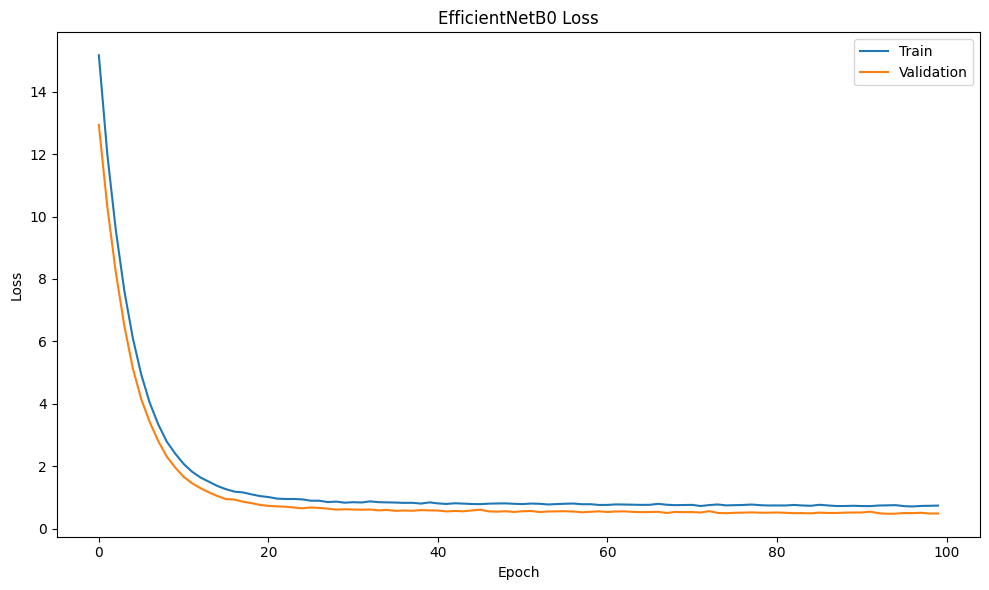

In [15]:
best_model, history, results = create_and_train_model(
    'EfficientNetB0',
    (train_images, train_labels_one_hot),
    (val_images, val_labels_one_hot),
    (test_images, test_labels_one_hot)
)

### v) Display metrics

In [16]:
metrics = display_metrics(
    best_model,
    (train_images, train_labels_one_hot),
    (val_images, val_labels_one_hot),
    (test_images, test_labels_one_hot),

)


                           MODEL PERFORMANCE METRICS                            
Metric         Training                 Validation               Test                     
--------------------------------------------------------------------------------
Evaluating on Training data...
Evaluating on Validation data...
Evaluating on Test data...
Accuracy       0.8641                   0.8697                   0.7275                   
Precision      0.8768                   0.8792                   0.7481                   
Recall         0.8641                   0.8697                   0.7275                   
AUC            0.9916                   0.9925                   0.9616                   
F1 Score       0.8631                   0.8679                   0.7264                   

Detailed Test Metrics:
Test Loss: 1.1604
Test Accuracy: 0.7275
Test Precision: 0.7481
Test F1 Score: 0.7264
Test Recall: 0.7275
Test AUC: 0.9616

Classification Report on Test Data:
              pre

### VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,984,009 (57.16 MB)

 Trainable params: 268,297 (1.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

Training with 760 steps per epoch
Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2548 - auc: 0.6650 - f1_score: 0.2420 - loss: 12.0702 - precision: 0.3279 - recall: 0.1404
Epoch 1: val_loss improved from inf to 9.25562, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.2550 - auc: 0.6651 - f1_score: 0.2421 - loss: 12.0689 - precision: 0.3280 - recall: 0.1405 - val_accuracy: 0.6421 - val_auc: 0.9163 - val_f1_score: 0.6172 - val_loss: 9.2556 - val_precision: 0.7204 - val_recall: 0.5526
Epoch 2/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5318 - auc: 0.8649 - f1_score: 0.5223 - loss: 9.2327 - precision: 0.6303 - recall: 0.4008
Epoch 2: val_loss improved from 9.25562 to 7.69351, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.5318 - auc: 0.8649 - f1_score: 0.5224 - loss: 9.2316 - precision: 0.6304 - recall: 0.4008 - val_accuracy: 0.7211 - val_auc: 0.9470 - val_f1_score: 0.7069 - val_loss: 7.6935 - val_precision: 0.7750 - val_recall: 0.6434
Epoch 3/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5923 - auc: 0.9043 - f1_score: 0.5803 - loss: 7.7635 - precision: 0.6881 - recall: 0.4699
Epoch 3: val_loss improved from 7.69351 to 6.52614, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.5924 - auc: 0.9043 - f1_score: 0.5804 - loss: 7.7627 - precision: 0.6881 - recall: 0.4700 - val_accuracy: 0.7605 - val_auc: 0.9634 - val_f1_score: 0.7494 - val_loss: 6.5261 - val_precision: 0.8032 - val_recall: 0.7197
Epoch 4/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6342 - auc: 0.9235 - f1_score: 0.6289 - loss: 6.6589 - precision: 0.7345 - recall: 0.5384
Epoch 4: val_loss improved from 6.52614 to 5.63630, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.6341 - auc: 0.9235 - f1_score: 0.6289 - loss: 6.6583 - precision: 0.7345 - recall: 0.5384 - val_accuracy: 0.7803 - val_auc: 0.9685 - val_f1_score: 0.7705 - val_loss: 5.6363 - val_precision: 0.8264 - val_recall: 0.7329
Epoch 5/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6502 - auc: 0.9338 - f1_score: 0.6503 - loss: 5.7806 - precision: 0.7484 - recall: 0.5474
Epoch 5: val_loss improved from 5.63630 to 4.85643, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.6502 - auc: 0.9338 - f1_score: 0.6503 - loss: 5.7801 - precision: 0.7484 - recall: 0.5475 - val_accuracy: 0.8000 - val_auc: 0.9755 - val_f1_score: 0.7923 - val_loss: 4.8564 - val_precision: 0.8443 - val_recall: 0.7632
Epoch 6/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6849 - auc: 0.9391 - f1_score: 0.6823 - loss: 5.0627 - precision: 0.7773 - recall: 0.5794
Epoch 6: val_loss improved from 4.85643 to 4.23357, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.6849 - auc: 0.9391 - f1_score: 0.6823 - loss: 5.0623 - precision: 0.7773 - recall: 0.5794 - val_accuracy: 0.8132 - val_auc: 0.9784 - val_f1_score: 0.8055 - val_loss: 4.2336 - val_precision: 0.8553 - val_recall: 0.7697
Epoch 7/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6901 - auc: 0.9473 - f1_score: 0.6900 - loss: 4.4385 - precision: 0.7785 - recall: 0.5945
Epoch 7: val_loss improved from 4.23357 to 3.71676, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.6901 - auc: 0.9472 - f1_score: 0.6900 - loss: 4.4383 - precision: 0.7785 - recall: 0.5945 - val_accuracy: 0.8184 - val_auc: 0.9809 - val_f1_score: 0.8108 - val_loss: 3.7168 - val_precision: 0.8613 - val_recall: 0.7763
Epoch 8/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7053 - auc: 0.9478 - f1_score: 0.7028 - loss: 3.9692 - precision: 0.7996 - recall: 0.6021
Epoch 8: val_loss improved from 3.71676 to 3.30038, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7053 - auc: 0.9478 - f1_score: 0.7028 - loss: 3.9689 - precision: 0.7996 - recall: 0.6021 - val_accuracy: 0.8132 - val_auc: 0.9806 - val_f1_score: 0.8091 - val_loss: 3.3004 - val_precision: 0.8675 - val_recall: 0.7750
Epoch 9/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7005 - auc: 0.9516 - f1_score: 0.6961 - loss: 3.5453 - precision: 0.8063 - recall: 0.6120
Epoch 9: val_loss improved from 3.30038 to 2.91421, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7005 - auc: 0.9516 - f1_score: 0.6961 - loss: 3.5451 - precision: 0.8063 - recall: 0.6120 - val_accuracy: 0.8303 - val_auc: 0.9837 - val_f1_score: 0.8271 - val_loss: 2.9142 - val_precision: 0.8755 - val_recall: 0.7961
Epoch 10/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7113 - auc: 0.9560 - f1_score: 0.7138 - loss: 3.1765 - precision: 0.8072 - recall: 0.6339
Epoch 10: val_loss improved from 2.91421 to 2.62466, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7113 - auc: 0.9560 - f1_score: 0.7138 - loss: 3.1762 - precision: 0.8072 - recall: 0.6339 - val_accuracy: 0.8382 - val_auc: 0.9817 - val_f1_score: 0.8335 - val_loss: 2.6247 - val_precision: 0.8784 - val_recall: 0.7987
Epoch 11/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7217 - auc: 0.9569 - f1_score: 0.7255 - loss: 2.8819 - precision: 0.8123 - recall: 0.6339
Epoch 11: val_loss improved from 2.62466 to 2.34367, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7217 - auc: 0.9569 - f1_score: 0.7255 - loss: 2.8817 - precision: 0.8123 - recall: 0.6339 - val_accuracy: 0.8329 - val_auc: 0.9829 - val_f1_score: 0.8300 - val_loss: 2.3437 - val_precision: 0.8761 - val_recall: 0.8092
Epoch 12/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7326 - auc: 0.9616 - f1_score: 0.7307 - loss: 2.6015 - precision: 0.8221 - recall: 0.6401
Epoch 12: val_loss improved from 2.34367 to 2.12139, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7326 - auc: 0.9616 - f1_score: 0.7308 - loss: 2.6014 - precision: 0.8221 - recall: 0.6401 - val_accuracy: 0.8500 - val_auc: 0.9845 - val_f1_score: 0.8460 - val_loss: 2.1214 - val_precision: 0.8911 - val_recall: 0.8184
Epoch 13/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7362 - auc: 0.9633 - f1_score: 0.7337 - loss: 2.3816 - precision: 0.8295 - recall: 0.6558
Epoch 13: val_loss improved from 2.12139 to 1.93385, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7362 - auc: 0.9633 - f1_score: 0.7337 - loss: 2.3815 - precision: 0.8295 - recall: 0.6558 - val_accuracy: 0.8474 - val_auc: 0.9852 - val_f1_score: 0.8449 - val_loss: 1.9338 - val_precision: 0.8882 - val_recall: 0.8053
Epoch 14/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7349 - auc: 0.9606 - f1_score: 0.7392 - loss: 2.2308 - precision: 0.8199 - recall: 0.6367
Epoch 14: val_loss improved from 1.93385 to 1.77404, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7349 - auc: 0.9606 - f1_score: 0.7393 - loss: 2.2307 - precision: 0.8199 - recall: 0.6367 - val_accuracy: 0.8579 - val_auc: 0.9851 - val_f1_score: 0.8548 - val_loss: 1.7740 - val_precision: 0.8924 - val_recall: 0.8184
Epoch 15/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7277 - auc: 0.9637 - f1_score: 0.7288 - loss: 2.0631 - precision: 0.8138 - recall: 0.6443
Epoch 15: val_loss improved from 1.77404 to 1.61384, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7278 - auc: 0.9637 - f1_score: 0.7289 - loss: 2.0629 - precision: 0.8138 - recall: 0.6443 - val_accuracy: 0.8645 - val_auc: 0.9877 - val_f1_score: 0.8628 - val_loss: 1.6138 - val_precision: 0.8925 - val_recall: 0.8303
Epoch 16/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7543 - auc: 0.9639 - f1_score: 0.7550 - loss: 1.9231 - precision: 0.8286 - recall: 0.6527
Epoch 16: val_loss improved from 1.61384 to 1.49642, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7543 - auc: 0.9639 - f1_score: 0.7550 - loss: 1.9230 - precision: 0.8286 - recall: 0.6527 - val_accuracy: 0.8776 - val_auc: 0.9878 - val_f1_score: 0.8765 - val_loss: 1.4964 - val_precision: 0.9041 - val_recall: 0.8316
Epoch 17/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7681 - auc: 0.9682 - f1_score: 0.7697 - loss: 1.7804 - precision: 0.8490 - recall: 0.6785
Epoch 17: val_loss improved from 1.49642 to 1.42502, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7680 - auc: 0.9682 - f1_score: 0.7697 - loss: 1.7804 - precision: 0.8490 - recall: 0.6784 - val_accuracy: 0.8632 - val_auc: 0.9860 - val_f1_score: 0.8615 - val_loss: 1.4250 - val_precision: 0.8933 - val_recall: 0.8263
Epoch 18/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7652 - auc: 0.9704 - f1_score: 0.7674 - loss: 1.6807 - precision: 0.8548 - recall: 0.6783
Epoch 18: val_loss improved from 1.42502 to 1.35973, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7652 - auc: 0.9704 - f1_score: 0.7674 - loss: 1.6806 - precision: 0.8548 - recall: 0.6783 - val_accuracy: 0.8526 - val_auc: 0.9858 - val_f1_score: 0.8506 - val_loss: 1.3597 - val_precision: 0.8902 - val_recall: 0.8211
Epoch 19/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7669 - auc: 0.9665 - f1_score: 0.7688 - loss: 1.6370 - precision: 0.8402 - recall: 0.6737
Epoch 19: val_loss improved from 1.35973 to 1.24736, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7669 - auc: 0.9665 - f1_score: 0.7688 - loss: 1.6370 - precision: 0.8402 - recall: 0.6737 - val_accuracy: 0.8684 - val_auc: 0.9890 - val_f1_score: 0.8689 - val_loss: 1.2474 - val_precision: 0.8983 - val_recall: 0.8368
Epoch 20/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7710 - auc: 0.9700 - f1_score: 0.7715 - loss: 1.5331 - precision: 0.8521 - recall: 0.6942
Epoch 20: val_loss improved from 1.24736 to 1.19264, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7710 - auc: 0.9700 - f1_score: 0.7715 - loss: 1.5331 - precision: 0.8521 - recall: 0.6942 - val_accuracy: 0.8671 - val_auc: 0.9891 - val_f1_score: 0.8667 - val_loss: 1.1926 - val_precision: 0.8989 - val_recall: 0.8303
Epoch 21/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7756 - auc: 0.9692 - f1_score: 0.7707 - loss: 1.4791 - precision: 0.8486 - recall: 0.6928
Epoch 21: val_loss improved from 1.19264 to 1.17832, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7756 - auc: 0.9692 - f1_score: 0.7707 - loss: 1.4791 - precision: 0.8486 - recall: 0.6928 - val_accuracy: 0.8500 - val_auc: 0.9849 - val_f1_score: 0.8481 - val_loss: 1.1783 - val_precision: 0.8851 - val_recall: 0.8211
Epoch 22/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7780 - auc: 0.9693 - f1_score: 0.7803 - loss: 1.4239 - precision: 0.8526 - recall: 0.6980
Epoch 22: val_loss improved from 1.17832 to 1.08049, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7780 - auc: 0.9693 - f1_score: 0.7803 - loss: 1.4239 - precision: 0.8525 - recall: 0.6980 - val_accuracy: 0.8671 - val_auc: 0.9886 - val_f1_score: 0.8668 - val_loss: 1.0805 - val_precision: 0.9109 - val_recall: 0.8474
Epoch 23/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7782 - auc: 0.9711 - f1_score: 0.7800 - loss: 1.3583 - precision: 0.8554 - recall: 0.7069
Epoch 23: val_loss improved from 1.08049 to 1.03280, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7782 - auc: 0.9711 - f1_score: 0.7800 - loss: 1.3583 - precision: 0.8553 - recall: 0.7069 - val_accuracy: 0.8737 - val_auc: 0.9899 - val_f1_score: 0.8712 - val_loss: 1.0328 - val_precision: 0.9061 - val_recall: 0.8382
Epoch 24/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7665 - auc: 0.9712 - f1_score: 0.7690 - loss: 1.3303 - precision: 0.8537 - recall: 0.6805
Epoch 24: val_loss improved from 1.03280 to 0.97689, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7665 - auc: 0.9712 - f1_score: 0.7690 - loss: 1.3303 - precision: 0.8537 - recall: 0.6805 - val_accuracy: 0.8895 - val_auc: 0.9908 - val_f1_score: 0.8854 - val_loss: 0.9769 - val_precision: 0.9078 - val_recall: 0.8553
Epoch 25/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7789 - auc: 0.9747 - f1_score: 0.7786 - loss: 1.2548 - precision: 0.8585 - recall: 0.6959
Epoch 25: val_loss did not improve from 0.97689
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7789 - auc: 0.9747 - f1_score: 0.7786 - loss: 1.2549 - precision: 0.8585 - recall: 0.6959 - val_accuracy: 0.8763 - val_auc: 0.9890 - val_f1_score: 0.8741 - val_loss: 0.9820 - val_precision: 0.8959 - val_recall: 0.8382
Epoch 26/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7874 - auc: 0.9757 - f1_score: 0.7907 - loss: 1.2195 - precision: 0.8712 - recall: 0.6879
Epoch 26: val_loss improved from 0.97689 to 0.95683, saving model to VGG16_best_mode

760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7873 - auc: 0.9757 - f1_score: 0.7907 - loss: 1.2195 - precision: 0.8711 - recall: 0.6879 - val_accuracy: 0.8618 - val_auc: 0.9881 - val_f1_score: 0.8530 - val_loss: 0.9568 - val_precision: 0.8933 - val_recall: 0.8368
Epoch 27/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7814 - auc: 0.9741 - f1_score: 0.7858 - loss: 1.2035 - precision: 0.8490 - recall: 0.6876
Epoch 27: val_loss improved from 0.95683 to 0.93076, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7814 - auc: 0.9741 - f1_score: 0.7858 - loss: 1.2035 - precision: 0.8490 - recall: 0.6876 - val_accuracy: 0.8566 - val_auc: 0.9889 - val_f1_score: 0.8532 - val_loss: 0.9308 - val_precision: 0.8935 - val_recall: 0.8276
Epoch 28/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7840 - auc: 0.9729 - f1_score: 0.7847 - loss: 1.1870 - precision: 0.8644 - recall: 0.6945
Epoch 28: val_loss improved from 0.93076 to 0.90213, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7839 - auc: 0.9729 - f1_score: 0.7847 - loss: 1.1870 - precision: 0.8644 - recall: 0.6945 - val_accuracy: 0.8737 - val_auc: 0.9896 - val_f1_score: 0.8666 - val_loss: 0.9021 - val_precision: 0.9027 - val_recall: 0.8421
Epoch 29/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7969 - auc: 0.9754 - f1_score: 0.7998 - loss: 1.1393 - precision: 0.8679 - recall: 0.7142
Epoch 29: val_loss improved from 0.90213 to 0.85423, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7969 - auc: 0.9754 - f1_score: 0.7998 - loss: 1.1393 - precision: 0.8679 - recall: 0.7142 - val_accuracy: 0.8789 - val_auc: 0.9906 - val_f1_score: 0.8745 - val_loss: 0.8542 - val_precision: 0.9085 - val_recall: 0.8487
Epoch 30/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7784 - auc: 0.9713 - f1_score: 0.7716 - loss: 1.1651 - precision: 0.8557 - recall: 0.6871
Epoch 30: val_loss improved from 0.85423 to 0.85156, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7784 - auc: 0.9713 - f1_score: 0.7716 - loss: 1.1651 - precision: 0.8557 - recall: 0.6871 - val_accuracy: 0.8763 - val_auc: 0.9894 - val_f1_score: 0.8742 - val_loss: 0.8516 - val_precision: 0.9104 - val_recall: 0.8553
Epoch 31/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7950 - auc: 0.9755 - f1_score: 0.8006 - loss: 1.1059 - precision: 0.8651 - recall: 0.7092
Epoch 31: val_loss improved from 0.85156 to 0.82826, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7950 - auc: 0.9755 - f1_score: 0.8005 - loss: 1.1060 - precision: 0.8650 - recall: 0.7092 - val_accuracy: 0.8789 - val_auc: 0.9896 - val_f1_score: 0.8782 - val_loss: 0.8283 - val_precision: 0.9121 - val_recall: 0.8461
Epoch 32/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7788 - auc: 0.9724 - f1_score: 0.7796 - loss: 1.1283 - precision: 0.8623 - recall: 0.6887
Epoch 32: val_loss improved from 0.82826 to 0.81097, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7789 - auc: 0.9724 - f1_score: 0.7796 - loss: 1.1283 - precision: 0.8623 - recall: 0.6888 - val_accuracy: 0.8737 - val_auc: 0.9907 - val_f1_score: 0.8715 - val_loss: 0.8110 - val_precision: 0.9030 - val_recall: 0.8447
Epoch 33/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8008 - auc: 0.9762 - f1_score: 0.7990 - loss: 1.0729 - precision: 0.8736 - recall: 0.7103
Epoch 33: val_loss improved from 0.81097 to 0.78446, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8007 - auc: 0.9762 - f1_score: 0.7990 - loss: 1.0729 - precision: 0.8736 - recall: 0.7103 - val_accuracy: 0.8921 - val_auc: 0.9899 - val_f1_score: 0.8920 - val_loss: 0.7845 - val_precision: 0.9176 - val_recall: 0.8645
Epoch 34/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7803 - auc: 0.9724 - f1_score: 0.7842 - loss: 1.1006 - precision: 0.8607 - recall: 0.6821
Epoch 34: val_loss did not improve from 0.78446
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7803 - auc: 0.9724 - f1_score: 0.7842 - loss: 1.1006 - precision: 0.8607 - recall: 0.6821 - val_accuracy: 0.8776 - val_auc: 0.9908 - val_f1_score: 0.8738 - val_loss: 0.7878 - val_precision: 0.9059 - val_recall: 0.8487
Epoch 35/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7856 - auc: 0.9753 - f1_score: 0.7868 - loss: 1.0590 - precision: 0.8662 - recall: 0.7020
Epoch 35: val_loss improved from 0.78446 to 0.76833, saving model to VGG16_best_mode

760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7856 - auc: 0.9753 - f1_score: 0.7868 - loss: 1.0590 - precision: 0.8661 - recall: 0.7020 - val_accuracy: 0.8750 - val_auc: 0.9902 - val_f1_score: 0.8707 - val_loss: 0.7683 - val_precision: 0.9153 - val_recall: 0.8526
Epoch 36/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7877 - auc: 0.9768 - f1_score: 0.7876 - loss: 1.0384 - precision: 0.8551 - recall: 0.7053
Epoch 36: val_loss did not improve from 0.76833
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7877 - auc: 0.9768 - f1_score: 0.7877 - loss: 1.0385 - precision: 0.8551 - recall: 0.7053 - val_accuracy: 0.8737 - val_auc: 0.9894 - val_f1_score: 0.8724 - val_loss: 0.7807 - val_precision: 0.9041 - val_recall: 0.8434
Epoch 37/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7930 - auc: 0.9740 - f1_score: 0.7992 - loss: 1.0490 - precision: 0.8722 - recall: 0.6978
Epoch 37: val_loss did not improve from 0.76833
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42m

760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7922 - auc: 0.9752 - f1_score: 0.7909 - loss: 1.0212 - precision: 0.8603 - recall: 0.7118 - val_accuracy: 0.8816 - val_auc: 0.9919 - val_f1_score: 0.8784 - val_loss: 0.7285 - val_precision: 0.9105 - val_recall: 0.8566
Epoch 39/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7955 - auc: 0.9775 - f1_score: 0.7956 - loss: 0.9935 - precision: 0.8712 - recall: 0.7126
Epoch 39: val_loss did not improve from 0.72851
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7954 - auc: 0.9775 - f1_score: 0.7956 - loss: 0.9936 - precision: 0.8712 - recall: 0.7125 - val_accuracy: 0.8803 - val_auc: 0.9915 - val_f1_score: 0.8782 - val_loss: 0.7391 - val_precision: 0.9048 - val_recall: 0.8500
Epoch 40/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7766 - auc: 0.9732 - f1_score: 0.7759 - loss: 1.0327 - precision: 0.8594 - recall: 0.7007
Epoch 40: val_loss did not improve from 0.72851
760/760 ━━━━━━━━━━━━━━━━━━━━ 31s 41m

760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7997 - auc: 0.9786 - f1_score: 0.8000 - loss: 0.9473 - precision: 0.8728 - recall: 0.7178 - val_accuracy: 0.8855 - val_auc: 0.9901 - val_f1_score: 0.8786 - val_loss: 0.7021 - val_precision: 0.9155 - val_recall: 0.8553
Epoch 46/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8003 - auc: 0.9735 - f1_score: 0.8021 - loss: 0.9862 - precision: 0.8758 - recall: 0.7210
Epoch 46: val_loss improved from 0.70215 to 0.68304, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8003 - auc: 0.9735 - f1_score: 0.8021 - loss: 0.9862 - precision: 0.8758 - recall: 0.7209 - val_accuracy: 0.8829 - val_auc: 0.9917 - val_f1_score: 0.8809 - val_loss: 0.6830 - val_precision: 0.9122 - val_recall: 0.8474
Epoch 47/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8042 - auc: 0.9803 - f1_score: 0.8090 - loss: 0.9198 - precision: 0.8806 - recall: 0.7211
Epoch 47: val_loss improved from 0.68304 to 0.68242, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8041 - auc: 0.9803 - f1_score: 0.8089 - loss: 0.9199 - precision: 0.8805 - recall: 0.7211 - val_accuracy: 0.8908 - val_auc: 0.9915 - val_f1_score: 0.8890 - val_loss: 0.6824 - val_precision: 0.9270 - val_recall: 0.8526
Epoch 48/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7784 - auc: 0.9735 - f1_score: 0.7794 - loss: 0.9864 - precision: 0.8627 - recall: 0.6938
Epoch 48: val_loss improved from 0.68242 to 0.66948, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7784 - auc: 0.9735 - f1_score: 0.7795 - loss: 0.9863 - precision: 0.8628 - recall: 0.6938 - val_accuracy: 0.8816 - val_auc: 0.9914 - val_f1_score: 0.8774 - val_loss: 0.6695 - val_precision: 0.9185 - val_recall: 0.8605
Epoch 49/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7846 - auc: 0.9732 - f1_score: 0.7862 - loss: 0.9793 - precision: 0.8554 - recall: 0.7009
Epoch 49: val_loss did not improve from 0.66948
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7846 - auc: 0.9732 - f1_score: 0.7863 - loss: 0.9793 - precision: 0.8554 - recall: 0.7008 - val_accuracy: 0.8658 - val_auc: 0.9884 - val_f1_score: 0.8642 - val_loss: 0.7198 - val_precision: 0.8966 - val_recall: 0.8329
Epoch 50/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7781 - auc: 0.9742 - f1_score: 0.7762 - loss: 0.9742 - precision: 0.8582 - recall: 0.6930
Epoch 50: val_loss did not improve from 0.66948
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41m

760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7816 - auc: 0.9766 - f1_score: 0.7851 - loss: 0.9487 - precision: 0.8656 - recall: 0.6943 - val_accuracy: 0.8842 - val_auc: 0.9923 - val_f1_score: 0.8823 - val_loss: 0.6578 - val_precision: 0.9182 - val_recall: 0.8566
Epoch 52/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7867 - auc: 0.9730 - f1_score: 0.7894 - loss: 0.9817 - precision: 0.8632 - recall: 0.6797
Epoch 52: val_loss did not improve from 0.65782
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7867 - auc: 0.9730 - f1_score: 0.7894 - loss: 0.9817 - precision: 0.8632 - recall: 0.6797 - val_accuracy: 0.8895 - val_auc: 0.9913 - val_f1_score: 0.8867 - val_loss: 0.6595 - val_precision: 0.9183 - val_recall: 0.8579
Epoch 53/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7985 - auc: 0.9759 - f1_score: 0.8003 - loss: 0.9436 - precision: 0.8745 - recall: 0.7100
Epoch 53: val_loss did not improve from 0.65782
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 41m

760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7988 - auc: 0.9774 - f1_score: 0.7984 - loss: 0.9112 - precision: 0.8739 - recall: 0.7228 - val_accuracy: 0.8908 - val_auc: 0.9906 - val_f1_score: 0.8875 - val_loss: 0.6506 - val_precision: 0.9142 - val_recall: 0.8553
Epoch 59/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7974 - auc: 0.9780 - f1_score: 0.7996 - loss: 0.9080 - precision: 0.8705 - recall: 0.7115
Epoch 59: val_loss improved from 0.65062 to 0.64646, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7974 - auc: 0.9780 - f1_score: 0.7996 - loss: 0.9081 - precision: 0.8705 - recall: 0.7115 - val_accuracy: 0.8947 - val_auc: 0.9904 - val_f1_score: 0.8902 - val_loss: 0.6465 - val_precision: 0.9185 - val_recall: 0.8605
Epoch 60/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8064 - auc: 0.9763 - f1_score: 0.8081 - loss: 0.9131 - precision: 0.8725 - recall: 0.7174
Epoch 60: val_loss improved from 0.64646 to 0.62306, saving model to VGG16_best_model.h5


760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8064 - auc: 0.9763 - f1_score: 0.8081 - loss: 0.9131 - precision: 0.8724 - recall: 0.7173 - val_accuracy: 0.9000 - val_auc: 0.9912 - val_f1_score: 0.8945 - val_loss: 0.6231 - val_precision: 0.9239 - val_recall: 0.8632
Epoch 61/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7932 - auc: 0.9776 - f1_score: 0.7915 - loss: 0.9041 - precision: 0.8630 - recall: 0.7042
Epoch 61: val_loss did not improve from 0.62306
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7932 - auc: 0.9776 - f1_score: 0.7915 - loss: 0.9041 - precision: 0.8630 - recall: 0.7042 - val_accuracy: 0.8803 - val_auc: 0.9887 - val_f1_score: 0.8755 - val_loss: 0.6638 - val_precision: 0.9118 - val_recall: 0.8566
Epoch 62/100
759/760 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7947 - auc: 0.9765 - f1_score: 0.7952 - loss: 0.9046 - precision: 0.8653 - recall: 0.7123
Epoch 62: val_loss did not improve from 0.62306
760/760 ━━━━━━━━━━━━━━━━━━━━ 32s 42m

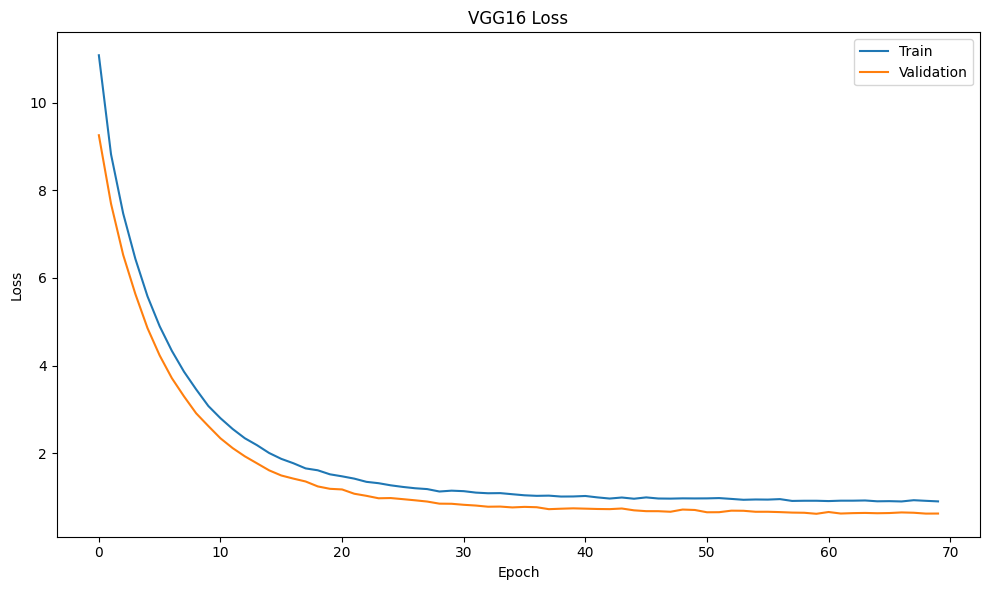

In [17]:
best_model, history, results = create_and_train_model(
    'VGG16',
    (train_images, train_labels_one_hot),
    (val_images, val_labels_one_hot),
    (test_images, test_labels_one_hot)
)

### V) Display metrics

In [18]:
metrics = display_metrics(
    best_model,
    (train_images, train_labels_one_hot),
    (val_images, val_labels_one_hot),
    (test_images, test_labels_one_hot),

)


                           MODEL PERFORMANCE METRICS                            
Metric         Training                 Validation               Test                     
--------------------------------------------------------------------------------
Evaluating on Training data...
Evaluating on Validation data...
Evaluating on Test data...
Accuracy       0.8963                   0.9000                   0.7327                   
Precision      0.8973                   0.9039                   0.7262                   
Recall         0.8963                   0.9000                   0.7327                   
AUC            0.9927                   0.9921                   0.9507                   
F1 Score       0.8953                   0.8987                   0.7195                   

Detailed Test Metrics:
Test Loss: 1.1655
Test Accuracy: 0.7327
Test Precision: 0.7262
Test F1 Score: 0.7195
Test Recall: 0.7327
Test AUC: 0.9507

Classification Report on Test Data:
              pre

### Conclusion

The test results for ResNet50: 76.31%<br>
The test results for ResNet101: 76.42%<br>
The test results for EfficientNetB0: 72.75%<br>
The test results for VGG16: 73.27%<br>
From these results we see that ResNet101 has the highest accuracy on test data and outperforms the rest but by a slight higher margin